## AML PROJECT - SMS SPAM DATASET

#### The execution of below code would roughly take 4 hours to run considering the variation of all the models and hyperparameters

In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sb
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import nltk
import re
from nltk.corpus import stopwords

The below path is local to the machine it needs to run on. Kindly update the path before running in order to avoid error

In [2]:
# Loading the dataset

sms_df = pd.read_csv("C:\\Users\\siddh\\Documents\\aml-notebooks\\spam.csv", encoding="latin-1")

In [3]:
# Dropping irrelevant columns and renaming the column names to our convenience

sms_df = sms_df.iloc[:,:2]
sms_df.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
sms_df.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# checking the count of the number of messages in ham and spam

sms_df.groupby('Target').describe()

Text                                                               
       count unique                                                top freq
Target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

#### As you can see, there 4825 text for ham and 747 text for spam suggesting imbalance in the dataset.

In [5]:
# Convert the label to a numeric variable

encode = LabelEncoder()
encode.fit(sms_df['Target'])
sms_df['Target_Encoded'] = encode.transform(sms_df['Target'])
sms_df.head()

,Target,Text,Target_Encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
# Generating the length of the message for each class

sms_df['Message_Length'] = sms_df.Text.apply(len)
sms_df.head()

,Target,Text,Target_Encoded,Message_Length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Message Length')

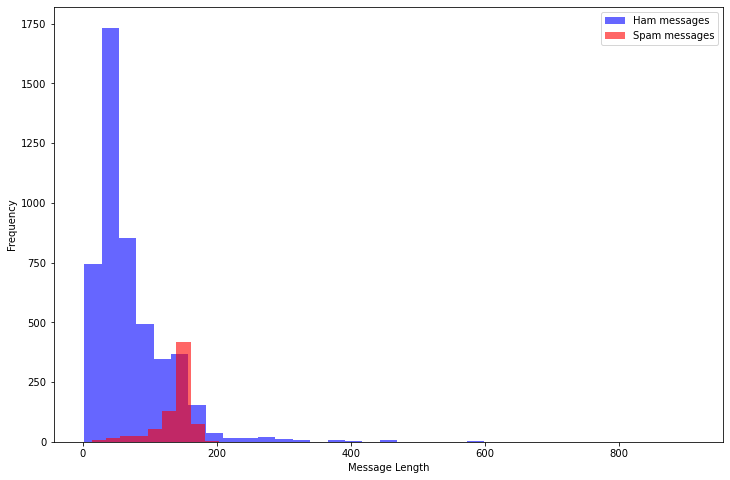

In [7]:
# plotting to check the length of words for our 2 classes

plt.figure(figsize=(12, 8))
sms_df[sms_df.Target == 'ham'].Message_Length.plot(bins=35, kind='hist', color='blue',
                                       label='Ham messages', alpha=0.6)
sms_df[sms_df.Target == 'spam'].Message_Length.plot(kind='hist', color='red',
                                        label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")

#### Looking at the trend, message length for ham messages are more compared to spam messages

In [8]:
text_data = sms_df
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Target          5572 non-null   object
 1   Text            5572 non-null   object
 2   Target_Encoded  5572 non-null   int32 
 3   Message_Length  5572 non-null   int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 152.5+ KB


# Data Preprocessing
### Removing stopwords, punctuations and specific patterns

In [9]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
more_stopwords = ['u', 'im', 'c', 'ü', 'ur', '4', '2', 'dont', 'doin', 'ure']
STOPWORDS = STOPWORDS + more_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
import string
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove urls
    text = re.sub('\n', '', text)
    text = " ".join(word for word in nopunc.split() if word not in STOPWORDS)
    return text

In [11]:
text_data['clean_text'] = text_data['Text'].apply(clean_text)
text_data.head()

,Target,Text,Target_Encoded,Message_Length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though


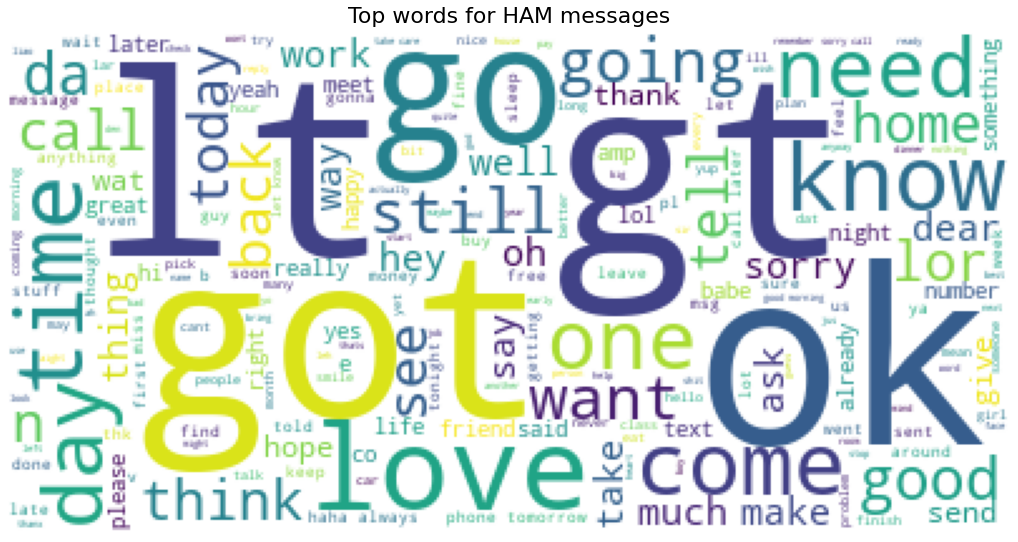

In [12]:
# Viewing the Top words for HAM messages using WordCloud

wc = WordCloud(background_color='white',max_words=200)
wc.generate(' '.join(text for text in text_data.loc[text_data['Target'] == 'ham', 'clean_text']))
plt.figure(figsize=(18,10))
plt.title('Top words for HAM messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

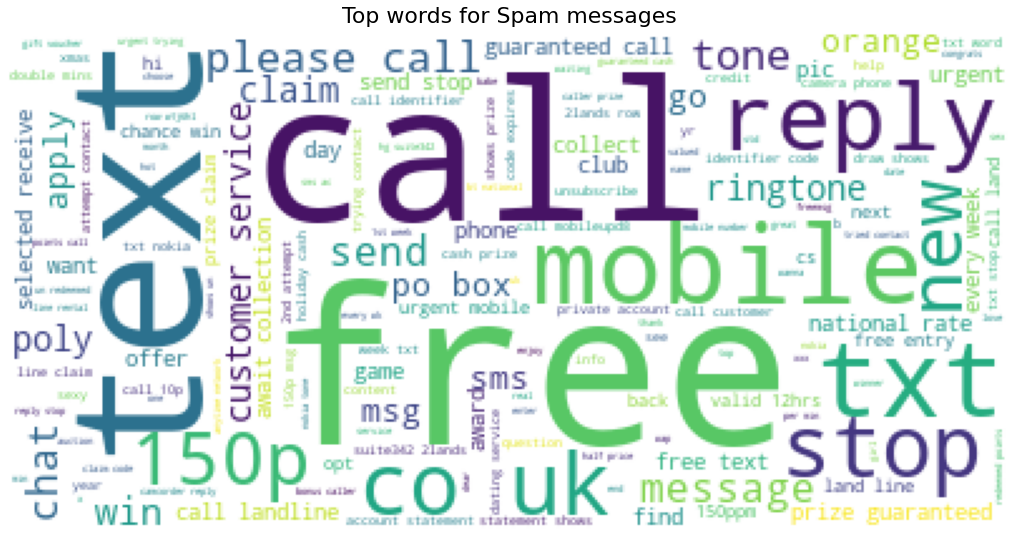

In [13]:
# Viewing the Top Words for SPAM messages using WordCloud

wc = WordCloud(background_color='white',max_words=200)
wc.generate(' '.join(text for text in text_data.loc[text_data['Target'] == 'spam', 'clean_text']))
plt.figure(figsize=(18,10))
plt.title('Top words for Spam messages',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Tokenization

In [14]:
import nltk
nltk.download('punkt')
text_data["tokenize_text"]=text_data.apply(lambda row: nltk.word_tokenize(row["clean_text"]), axis=1)
text_data

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Target,Text,Target_Encoded,Message_Length,clean_text,tokenize_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni,"[ok, lar, joking, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor already say,"[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]"
...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,2nd time tried contact 750 pound prize claim e...,"[2nd, time, tried, contact, 750, pound, prize,..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,b going esplanade fr home,"[b, going, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,pity mood suggestions,"[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,0,125,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin..."


# Lemmatization - getting the root of the words

In [15]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

text_data["lemmatized_text"] = text_data["tokenize_text"].apply(lemmatize_word)
text_data

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\siddh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Target,Text,Target_Encoded,Message_Length,clean_text,tokenize_text,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif oni,"[ok, lar, joking, wif, oni]","[ok, lar, joke, wif, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts 21s...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,0,49,dun say early hor already say,"[dun, say, early, hor, already, say]","[dun, say, early, hor, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think goes usf lives around though,"[nah, think, goes, usf, lives, around, though]","[nah, think, go, usf, live, around, though]"
...,...,...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1,161,2nd time tried contact 750 pound prize claim e...,"[2nd, time, tried, contact, 750, pound, prize,...","[2nd, time, try, contact, 750, pound, prize, c..."
5568,ham,Will Ì_ b going to esplanade fr home?,0,37,b going esplanade fr home,"[b, going, esplanade, fr, home]","[b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...",0,57,pity mood suggestions,"[pity, mood, suggestions]","[pity, mood, suggestions]"
5570,ham,The guy did some bitching but I acted like i'd...,0,125,guy bitching acted like interested buying some...,"[guy, bitching, acted, like, interested, buyin...","[guy, bitch, act, like, interest, buy, somethi..."


# Vectorization techniques

In [16]:
# count vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus= []
for i in text_data["lemmatized_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]

cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=2500)



In [17]:
X = tfidf.fit_transform(corpus).toarray()
X1 = cv.fit_transform(corpus).toarray()

y = text_data['Target_Encoded']
X.shape, y.shape

((5572, 2500), (5572,))

In [18]:
# Split test and train data with tfidf transform

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
len(X_train), len(y_train), len(X_test), len(y_test)

(4457, 4457, 1115, 1115)

In [19]:
# Split test and train data with cv transform

X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size = 0.2, random_state=0)
len(X_train_cv), len(y_train_cv), len(X_test_cv), len(y_test_cv)

(4457, 4457, 1115, 1115)

# Building word2vec Model and spliting the data

In [20]:
# Defining the dimensions

w2v_dim = 100

In [21]:
# Fitting the word to vec model to our text messages corpus

model_w2v = Word2Vec(text_data['lemmatized_text'], min_count=5, size=w2v_dim, workers=4)

In [22]:
def text_to_w2v(x_w):
    word2vec = list()
    for splitSent in x_w:
        temp = np.zeros(w2v_dim)
        word_count = 0
        for word in splitSent:
            try:
                vect = model_w2v.wv[word]
            except KeyError:
                vect = np.zeros(w2v_dim)
            except Exception as e:
                print(e)
            temp += vect
            word_count += 1
        if word_count != 0:
            temp /= word_count
        else:
            temp = np.zeros(w2v_dim)
        word2vec.append(temp)
    return word2vec

In [23]:
# Splitting the data for training models on word2vec

X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(text_data['lemmatized_text'].values, y, test_size = 0.2, random_state=0)

In [24]:
# Building the train and test word2vec data

wordVecTrain = text_to_w2v(X_train_w2v)
wordVecTest = text_to_w2v(X_test_w2v)

# Model Implementation with TFIDF transformation

In [25]:
# Confusion matrix heat map

def confusionmatrix_heatmap(matrix, reg, acc):
    ax = plt.axes()
    sb.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title("c = {} and accuracy = {}".format(reg, acc))
    plt.show()

In [26]:
# Heat map NB and RF

def confusionmatrix_heatmap_NB_RF(matrix, acc):
    ax = plt.axes()
    sb.heatmap(matrix, annot=True, cmap='Blues')
    ax.set_title("The accuracy is {}".format(acc))
    plt.show()

In [27]:
# Computing the logistic regression

def logistic_regression(r, x, y, xt, yt, regularization):

    if regularization == "l2 reg":
        logReg = LogisticRegression(penalty='l2', C=r, solver='sag', random_state=0)
        # print("reg is l2")
    elif regularization == "l1 reg":
        logReg = LogisticRegression(penalty='l1', C=r, solver='saga', random_state=0)
        print("reg is l1")
    else:
        print("You have chosen the wrong choice penalty")

    model = logReg.fit(x, y)
    ypred = model.predict(xt)
    accuracy = accuracy_score(yt, ypred)
    error_rate = 1 - accuracy
    confusionMatrix = confusion_matrix(yt, ypred)
    pred_prob = logReg.predict_proba(xt)
    confusionmatrix_heatmap(confusionMatrix, r, accuracy)
    # feature_importance()
    return ypred, pred_prob, logReg, error_rate

# Naive Bayes

In [28]:
#Defining a naive bayes function to fit a model assuming normal, multinomial and categorical distribution

def naiveBayes(x, y, xt, yt, distribution):

    if distribution == "Normal":
        nB = GaussianNB()
    elif distribution == "Multinomial":
        nB = MultinomialNB()
    else:
        print("You have chosen an invalid distribution")

    model = nB.fit(x, y)
    ypred = model.predict(xt)
    accuracy = accuracy_score(yt, ypred)
    error_rate = 1 - accuracy
    mse = mean_squared_error(yt, ypred)
    confusionMatrix = confusion_matrix(yt, ypred)
    confusionmatrix_heatmap_NB_RF(confusionMatrix,accuracy)
    pred_prob = nB.predict_proba(xt)
    sensitivity =  confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
    classificationReport = classification_report(yt, ypred)
    print("{} distribution Naive Bayes model accuracy = {}, error rate = {}\n".format(distribution, accuracy, error_rate) )
    print("{} distribution confusion Matrix: \n{}\n".format(distribution, confusionMatrix))
    print("{} distribution classification Report: \n{}\n".format(distribution, classificationReport))
    return ypred, pred_prob

## Naive Bayes with Normal Distribution

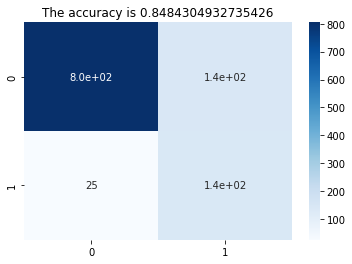

Normal distribution Naive Bayes model accuracy = 0.8484304932735426, error rate = 0.15156950672645741

Normal distribution confusion Matrix: 
[[805 144]
 [ 25 141]]

Normal distribution classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       949
           1       0.49      0.85      0.63       166

    accuracy                           0.85      1115
   macro avg       0.73      0.85      0.77      1115
weighted avg       0.90      0.85      0.86      1115




In [29]:
#Computing NaiveBayes with Normal Distribution

pred_y, prob_pred = naiveBayes(X_train, y_train, X_test, y_test, "Normal")

## Naive Bayes with Mutinomial Distribution

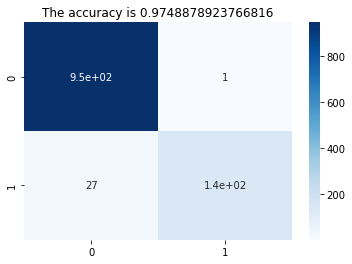

Multinomial distribution Naive Bayes model accuracy = 0.9748878923766816, error rate = 0.02511210762331839

Multinomial distribution confusion Matrix: 
[[948   1]
 [ 27 139]]

Multinomial distribution classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       949
           1       0.99      0.84      0.91       166

    accuracy                           0.97      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.97      0.97      1115




In [30]:
#Computing NaiveBayes with Multinomial Distribution

pred_y, prob_pred = naiveBayes(X_train, y_train, X_test, y_test, "Multinomial")

## Naive Bayes with Categorical Distribution

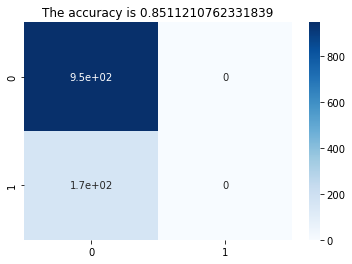

Categorical Naive Bayes model accuracy = 0.8511210762331839, error rate = 0.1488789237668161

Categorical distribution confusion Matrix: 
[[949   0]
 [166   0]]

Categorical distribution classification Report: 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       949
           1       0.00      0.00      0.00       166

    accuracy                           0.85      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.72      0.85      0.78      1115




C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
#Computing Naivebayes with Categorical Distribution

nBc = CategoricalNB(min_categories=2)
nBc.fit(X_train, y_train)
ypred_Cd = nBc.predict(X_test)
accuracy = accuracy_score(y_test, ypred_Cd)
error_rate = 1 - accuracy
mse = mean_squared_error(y_test, ypred_Cd)
confusionMatrix = confusion_matrix(y_test, ypred_Cd)
confusionmatrix_heatmap_NB_RF(confusionMatrix,accuracy)
sensitivity = confusionMatrix[0, 0] / (confusionMatrix[0, 0] + confusionMatrix[0, 1])
pred_prob = nBc.predict_proba(X_test)
classificationReport = classification_report(y_test, ypred_Cd)
print("Categorical Naive Bayes model accuracy = {}, error rate = {}\n".format(accuracy, error_rate))
print("Categorical distribution confusion Matrix: \n{}\n".format(confusionMatrix))
print("Categorical distribution classification Report: \n{}\n".format(classificationReport))

# Logistic Regression



Number of mislabeled points out of a total 1115 points : 43
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       949
           1       0.99      0.75      0.85       166

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.92      1115
weighted avg       0.96      0.96      0.96      1115

The confusion matrix:
 [[948   1]
 [ 42 124]]
Error rate: 0.039


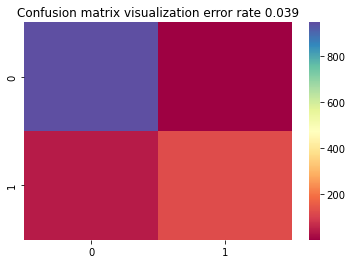

In [32]:
#Testing Linear Logistic regression without PCA

log_rig=LogisticRegression()
log_rig.fit(X_train, y_train)
y_pred=log_rig.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
C=confusion_matrix(y_test, y_pred)
print(classification_report(y_test,y_pred))
print("The confusion matrix:\n", C)
print("Error rate: %5.3f"%   (1.-sum(np.diag(C))/C.sum()))
sb.heatmap(C, cmap="Spectral")
plt.title(f"Confusion matrix visualization error rate {(1.-sum(np.diag(C))/C.sum()):3.2}")
plt.show()

Number of mislabeled points out of a total 1115 points after PCA: 34
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       978
           1       0.99      0.76      0.86       137

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115

The confusion matrix:
 [[977   1]
 [ 33 104]]
Error rate: 0.030


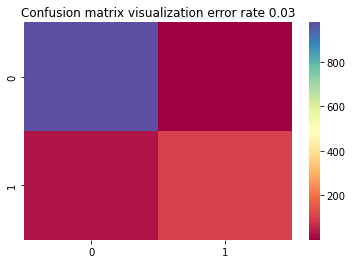

In [33]:
# Logistic Regression with PCA
r=0.8 #
pca1=PCA(n_components=r)
X_pca=pca1.fit_transform(X)
# Now split into train and test sets. We use the same seed so the split is
# consistent with the split above for the data with full set of features:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y,test_size=0.2,random_state=5)
# Build the logsitic regression model for the principal componenet features:
log_rig_pca=LogisticRegression(max_iter=1000)
log_rig_pca.fit(X_train_pca, y_train)
y_pred_pca=log_rig_pca.predict(X_test_pca) # predic on the test set
print(f"Number of mislabeled points out of a total {X_test.shape[0]} points after PCA: {(y_test != y_pred_pca).sum()}")

C=confusion_matrix(y_test, y_pred_pca)
print(classification_report(y_test,y_pred_pca))
print("The confusion matrix:\n", C)
print("Error rate: %5.3f"%   (1.-sum(np.diag(C))/C.sum()))
sb.heatmap(C, cmap="Spectral")
plt.title(f"Confusion matrix visualization error rate {(1.-sum(np.diag(C))/C.sum()):3.2}")
plt.show()

0.6
Number of mislabeled points out of a total 1115 points after PCA: 39
Error rate: 0.035
The confusion matrix:
 [[977   1]
 [ 38  99]]


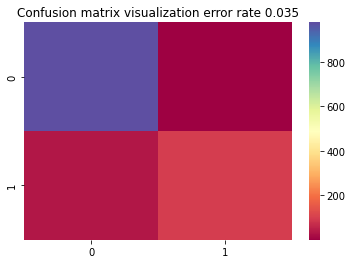

0.61
Number of mislabeled points out of a total 1115 points after PCA: 39
Error rate: 0.035
The confusion matrix:
 [[977   1]
 [ 38  99]]


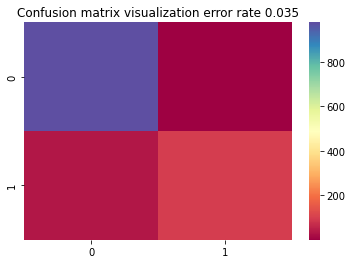

0.62
Number of mislabeled points out of a total 1115 points after PCA: 39
Error rate: 0.035
The confusion matrix:
 [[977   1]
 [ 38  99]]


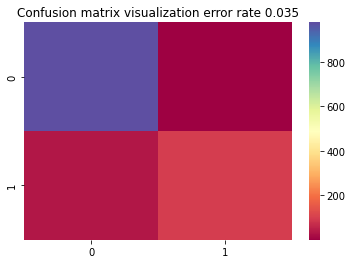

0.63
Number of mislabeled points out of a total 1115 points after PCA: 39
Error rate: 0.035
The confusion matrix:
 [[977   1]
 [ 38  99]]


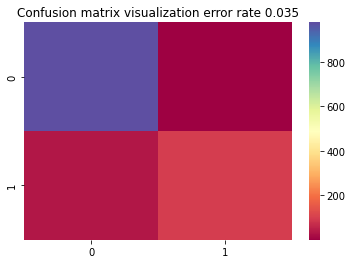

0.64
Number of mislabeled points out of a total 1115 points after PCA: 37
Error rate: 0.033
The confusion matrix:
 [[977   1]
 [ 36 101]]


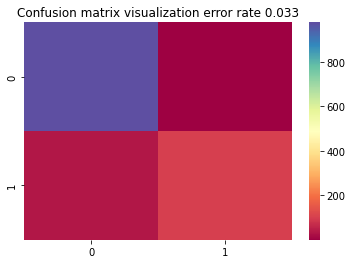

0.65
Number of mislabeled points out of a total 1115 points after PCA: 38
Error rate: 0.034
The confusion matrix:
 [[977   1]
 [ 37 100]]


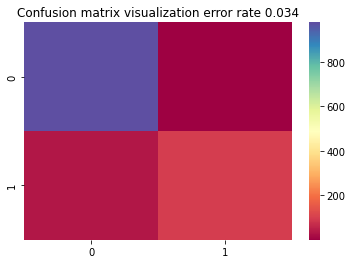

0.66
Number of mislabeled points out of a total 1115 points after PCA: 38
Error rate: 0.034
The confusion matrix:
 [[977   1]
 [ 37 100]]


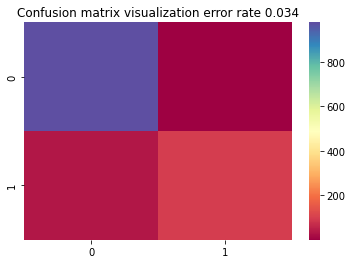

0.67
Number of mislabeled points out of a total 1115 points after PCA: 36
Error rate: 0.032
The confusion matrix:
 [[977   1]
 [ 35 102]]


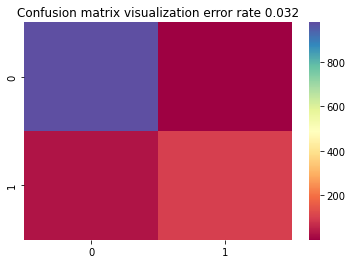

0.68
Number of mislabeled points out of a total 1115 points after PCA: 34
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 33 104]]


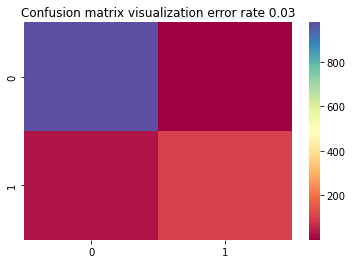

0.6900000000000001
Number of mislabeled points out of a total 1115 points after PCA: 34
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 33 104]]


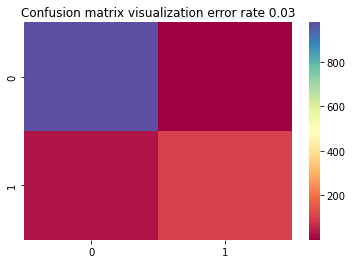

0.7000000000000001
Number of mislabeled points out of a total 1115 points after PCA: 34
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 33 104]]


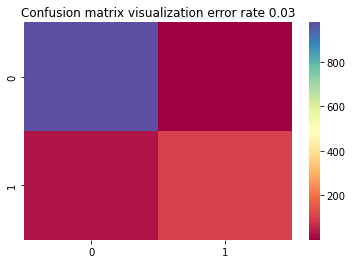

0.7100000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


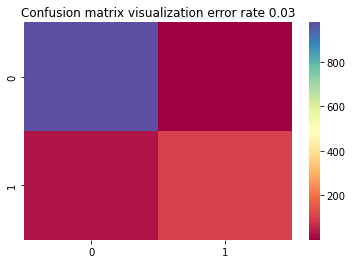

0.7200000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


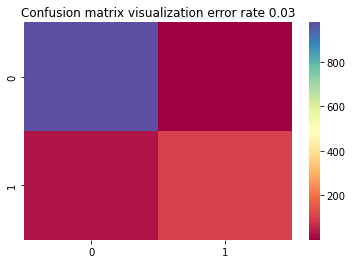

0.7300000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


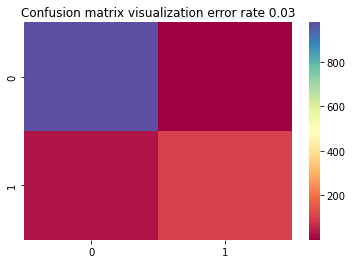

0.7400000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


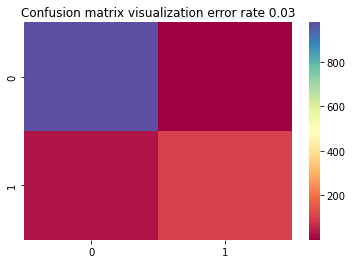

0.7500000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


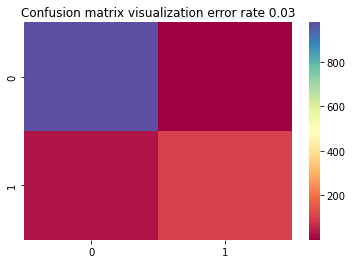

0.7600000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


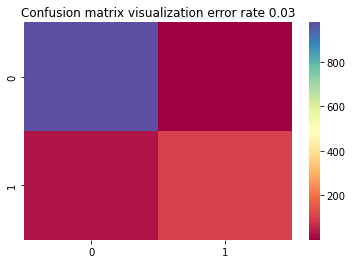

0.7700000000000001
Number of mislabeled points out of a total 1115 points after PCA: 33
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 32 105]]


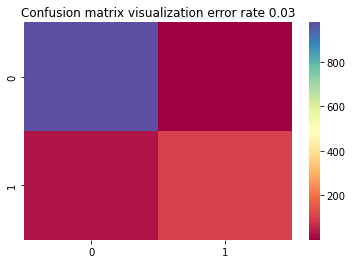

0.7800000000000001
Number of mislabeled points out of a total 1115 points after PCA: 34
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 33 104]]


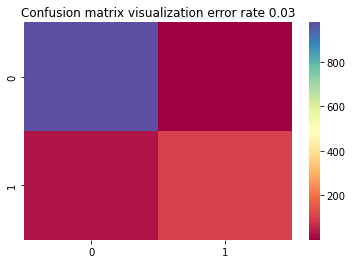

0.7900000000000001
Number of mislabeled points out of a total 1115 points after PCA: 34
Error rate: 0.030
The confusion matrix:
 [[977   1]
 [ 33 104]]


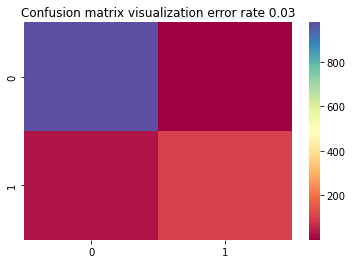

In [34]:
# Logistic Regression with PCA with multiple n_components

r = 0.6
while r <= 0.8:
    #r=0.8 #
    pca1=PCA(n_components=r)
    X_pca=pca1.fit_transform(X)
    # Now split into train and test sets. We use the same seed so the split is
    # consistent with the split above for the data with full set of features:
    X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca,y,test_size=0.2,random_state=5)
    # Build the logsitic regression model for the principal componenet features:
    log_rig_pca=LogisticRegression(max_iter=1000)
    log_rig_pca.fit(X_train_pca, y_train)
    y_pred_pca=log_rig_pca.predict(X_test_pca) # predict on the test set
    print(r)
    print(f"Number of mislabeled points out of a total {X_test.shape[0]} points after PCA: {(y_test != y_pred_pca).sum()}")

    C=confusion_matrix(y_test, y_pred_pca)
    print("Error rate: %5.3f"%   (1.-sum(np.diag(C))/C.sum()))
    print("The confusion matrix:\n", C)
    r += 0.01

    sns.heatmap(C, cmap="Spectral")
    plt.title(f"Confusion matrix visualization error rate {(1.-sum(np.diag(C))/C.sum()):3.2}")
    plt.show()

## KNN

In [35]:
#Computing KNN classifier

def gridSearch_cls(x, y):
    knnCls = KNeighborsClassifier()
    parameters = {'n_neighbors': np.arange(1, 202, 10)}
    gsKnn = GridSearchCV(knnCls, parameters, cv = 5)
    gsKnn.fit(x, y)
    print("GridSearch K-nearest neighbors best fit k value: {} ".format(gsKnn.best_params_))

gridSearch_cls(X_train, y_train)

GridSearch K-nearest neighbors best fit k value: {'n_neighbors': 11} 


In [36]:
#Computing Cross Val Score

def cvs_cls(x, y):

    for k in range(1, 202, 10):
        knnCv = KNeighborsClassifier(k)
        cvScore = cross_val_score(knnCv, x, y, cv = 5)
        print("CV score {} for K-value {}".format(cvScore, k))

cvs_cls(X_train, y_train)

CV score [0.81950673 0.8161435  0.80920314 0.82716049 0.82491582] for K-value 1
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 11
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 21
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 31
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 41
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 51
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 61
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 71
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 81
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 91
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 101
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 111
CV score [0.8632287 0.8632287 0.8630752 0.8630752 0.8630752] for K-value 121
CV sc

accuracy is 0.8295964125560538 for k = 1
accuracy is 0.8771300448430494 for k = 11
accuracy is 0.8771300448430494 for k = 21
accuracy is 0.8771300448430494 for k = 31
accuracy is 0.8771300448430494 for k = 41
accuracy is 0.8771300448430494 for k = 51
accuracy is 0.8771300448430494 for k = 61
accuracy is 0.8771300448430494 for k = 71
accuracy is 0.8771300448430494 for k = 81
accuracy is 0.8771300448430494 for k = 91
accuracy is 0.8771300448430494 for k = 101
accuracy is 0.8771300448430494 for k = 111
accuracy is 0.8771300448430494 for k = 121
accuracy is 0.8771300448430494 for k = 131
accuracy is 0.8771300448430494 for k = 141
accuracy is 0.8771300448430494 for k = 151
accuracy is 0.8771300448430494 for k = 161
accuracy is 0.8771300448430494 for k = 171
accuracy is 0.8771300448430494 for k = 181
accuracy is 0.8771300448430494 for k = 191
accuracy is 0.8771300448430494 for k = 201


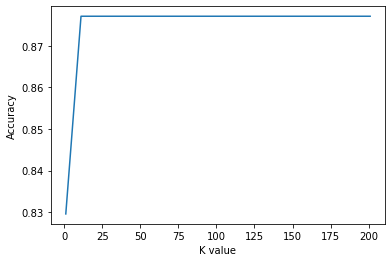

In [37]:
#Computing graph for accuracy vs k

def mvk_knncls(train_x, train_y, test_x, test_y):

    acc = []
    kvalue=[]
    for k in range(1, 202, 10):
        knnCls = KNeighborsClassifier(k)
        knnCls.fit(train_x, train_y)
        ypred = knnCls.predict(test_x)
        accuracy = accuracy_score(test_y, ypred)
        print("accuracy is {} for k = {}".format(accuracy, k))
        #         mSe = mean_squared_error(test_y, ypred)
        #         print("The Mse for k = {} is {}".format(k, mSe))
        #         rSquare = r2_score(test_y, ypred)
        #         print("The R2 Score for k = {} is {}".format(k, rSquare))
        acc.append(accuracy)
        kvalue.append(k)


    plt.xlabel("K value")
    plt.ylabel("Accuracy")
    plt.plot(kvalue, acc)

mvk_knncls(X_train, y_train, X_test, y_test)

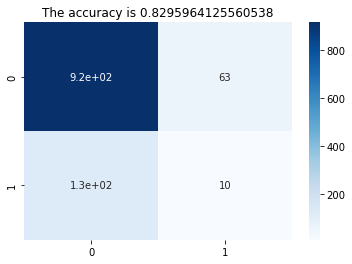

knn model accuracy = 0.8295964125560538, error rate = 0.17040358744394624

Confusion Matrix: 
[[915  63]
 [127  10]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       978
           1       0.14      0.07      0.10       137

    accuracy                           0.83      1115
   macro avg       0.51      0.50      0.50      1115
weighted avg       0.79      0.83      0.81      1115




In [38]:
# Predicting with best K value which is 1

def knn_predict(train_x, train_y, test_x, test_y, n):

    knnCls = KNeighborsClassifier(n)
    knnCls.fit(train_x, train_y)
    ypred = knnCls.predict(test_x)
    accuracy = accuracy_score(test_y, ypred)
    errorRate = 1 - accuracy
    confusionMatrix_knn = confusion_matrix(test_y, ypred)
    confusionmatrix_heatmap_NB_RF(confusionMatrix_knn, accuracy)
    sensitivity =  confusionMatrix_knn[0,0] / (confusionMatrix_knn[0,0] + confusionMatrix_knn[0,1])
    pred_prob = knnCls.predict_proba(test_x)
    classificationReport_knn = classification_report(test_y, ypred)
    print("knn model accuracy = {}, error rate = {}\n".format(accuracy, errorRate))
    print("Confusion Matrix: \n{}\n".format(confusionMatrix_knn))
    print("Classification Report: \n{}\n".format(classificationReport_knn))
    return knnCls

model_knnCls = knn_predict(X_train, y_train, X_test, y_test,1)

# Random Forest

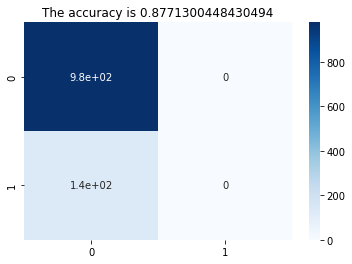

Random Forest model, accuracy is 0.8771300448430494, mse is 0.12286995515695068
Its out of bag score is 0.8631366389948396, test error is 0.12286995515695065


In [39]:
#Computing random forest on data

def randomForest(x_train, y_train, x_test, y_test):
    rf = RandomForestClassifier(n_estimators = 500, min_samples_leaf = 16, oob_score = True)
    rf.fit(x_train, y_train)
    ypred = rf.predict(x_test)
    accuracy = accuracy_score(y_test, ypred)
    test_error = 1 - accuracy
    confusionMatrix_rf = confusion_matrix(y_test, ypred)
    confusionmatrix_heatmap_NB_RF(confusionMatrix_rf, accuracy)
    mse = mean_squared_error(y_test, ypred)
    pred_prob = rf.predict_proba(x_test)
    #     rsq =r2_score(y_test, ypred)
    oobScore = rf.oob_score_
    print("Random Forest model, accuracy is {}, mse is {}".format(accuracy, mse))
    print("Its out of bag score is {}, test error is {}".format(oobScore, test_error))
    return rf, ypred, pred_prob

model_rf, predy, prob_pred = randomForest(X_train, y_train, X_test, y_test)

# Support Vector Machines

In [40]:
# Defining Regularization Parameters

reg_parameters = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

In [41]:
# Computing the SVM multiclass

def svM(c, x, y, xt, yt, kr, deg):
    if kr == "linear":
        svm = SVC(C=c, kernel=kr, probability=True)
    elif kr == "rbf":
        svm = SVC(C=c, kernel=kr, probability=True)
    elif kr == "poly" and deg == 3:
        svm = SVC(C=c, kernel=kr, degree=deg, probability=True)
    elif kr == "poly" and deg == 5:
        svm = SVC(C=c, kernel=kr, degree=deg, probability=True)
    elif kr == "poly" and deg == 10:
        svm = SVC(C=c, kernel=kr, degree=deg, probability=True)
    else:
        print("Choose the right kernel")

    model_svm = svm.fit(x, y)
    ypred = model_svm.predict(xt)
    accuracy = accuracy_score(yt, ypred)
    error_rate = 1 - accuracy
    confusion_matrix_svm = confusion_matrix(yt, ypred)
    pred_prob = svm.predict_proba(xt)
    # accuracy_from_matrix = sum(np.diag(confusion_matrix_svm))/confusion_matrix_svm.sum()
    # print("Accuracy from function is", accuracy)
    # print("Accuracy from confusion matrix is", accuracy_from_matr)
    # confusionmatrix_heatmap(confusion_matrix_svm, c, accuracy)
    confusionmatrix_heatmap(confusion_matrix_svm, c, accuracy)

    return ypred, pred_prob, svm, error_rate

Executing SVM Linear Kernel for C value 0.0001


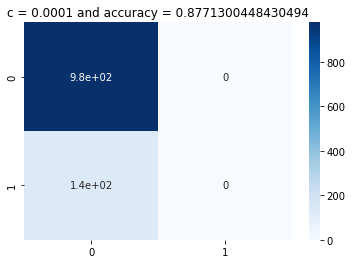

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM Linear Kernel for C value 0.001


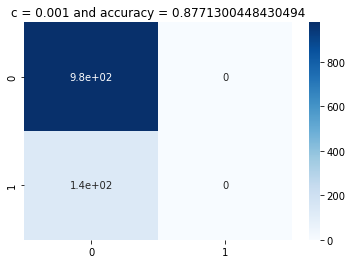

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM Linear Kernel for C value 0.01


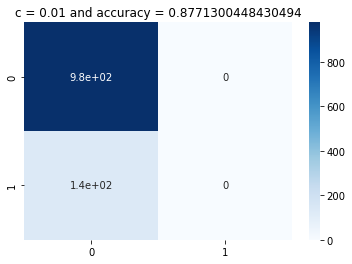

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM Linear Kernel for C value 0.1


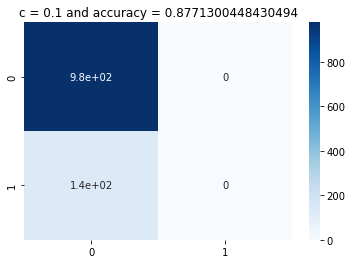

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM Linear Kernel for C value 1


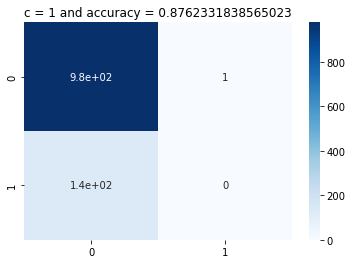

The error rate is 0.12376681614349772, accuracy is 0.8762331838565023 for c = 1
Executing SVM Linear Kernel for C value 10


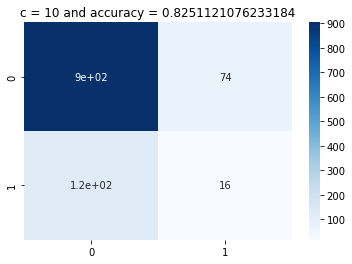

The error rate is 0.17488789237668156, accuracy is 0.8251121076233184 for c = 10
Executing SVM Linear Kernel for C value 100


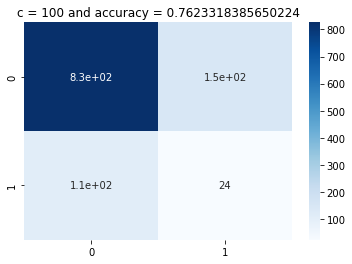

The error rate is 0.2376681614349776, accuracy is 0.7623318385650224 for c = 100


In [42]:
# Executing SVM with linear kernel

for c in reg_parameters:
    print("Executing SVM Linear Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train, y_train, X_test, y_test, "linear", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM RBF Kernel for C value 0.0001


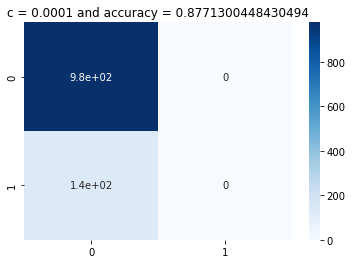

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM RBF Kernel for C value 0.001


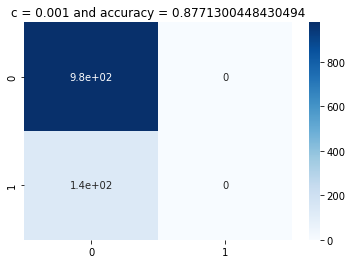

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM RBF Kernel for C value 0.01


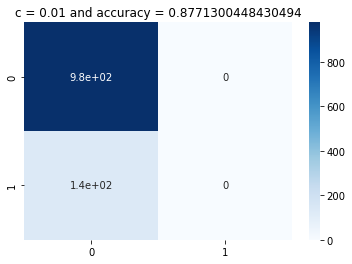

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM RBF Kernel for C value 0.1


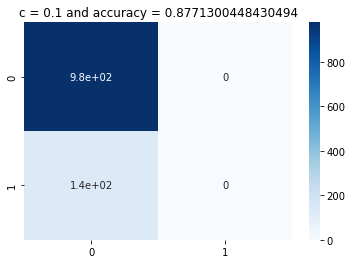

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM RBF Kernel for C value 1


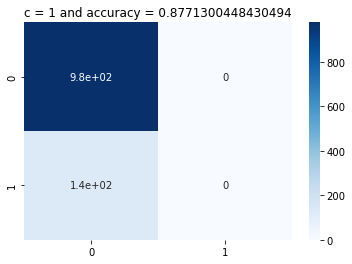

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing SVM RBF Kernel for C value 10


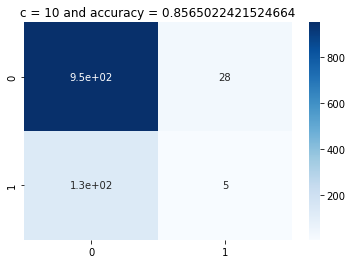

The error rate is 0.1434977578475336, accuracy is 0.8565022421524664 for c = 10
Executing SVM RBF Kernel for C value 100


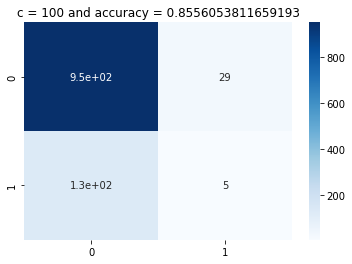

The error rate is 0.14439461883408067, accuracy is 0.8556053811659193 for c = 100


In [43]:
# Executing SVM with RBF kernel

for c in reg_parameters:
    print("Executing SVM RBF Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train, y_train, X_test, y_test, "rbf", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM Poly Kernel with degree 3 for C value 0.0001


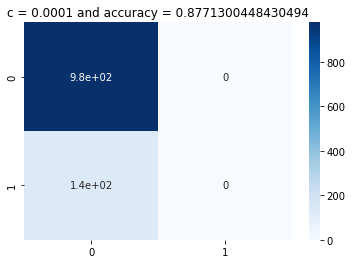

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM Poly Kernel with degree 3 for C value 0.001


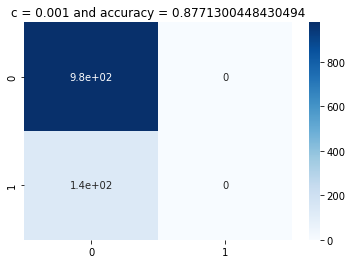

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM Poly Kernel with degree 3 for C value 0.01


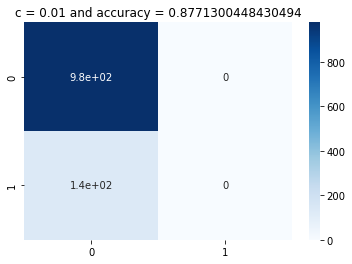

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM Poly Kernel with degree 3 for C value 0.1


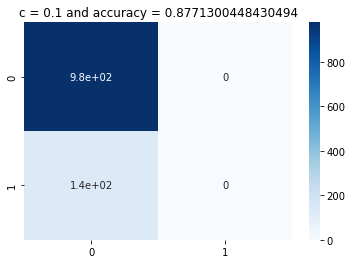

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM Poly Kernel with degree 3 for C value 1


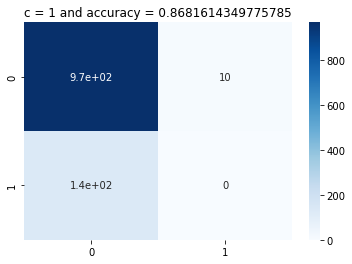

The error rate is 0.13183856502242153, accuracy is 0.8681614349775785 for c = 1
Executing SVM Poly Kernel with degree 3 for C value 10


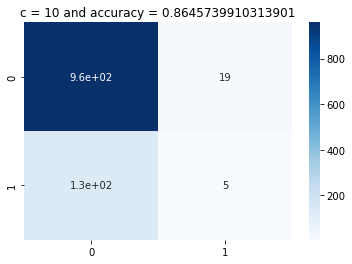

The error rate is 0.1354260089686099, accuracy is 0.8645739910313901 for c = 10
Executing SVM Poly Kernel with degree 3 for C value 100


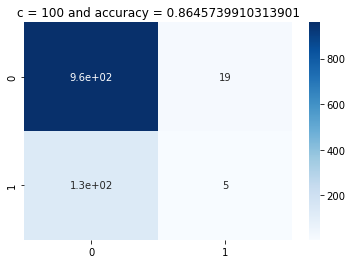

The error rate is 0.1354260089686099, accuracy is 0.8645739910313901 for c = 100


In [44]:
# Executing SVM with Poly kernel and degree 3

for c in reg_parameters:
    print("Executing SVM Poly Kernel with degree 3 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train, y_train, X_test, y_test, "poly", 3)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 5 for C value 0.0001


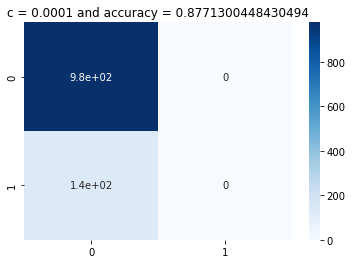

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM poly kernel with degree 5 for C value 0.001


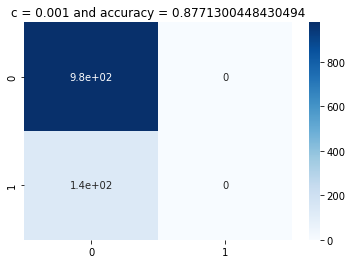

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM poly kernel with degree 5 for C value 0.01


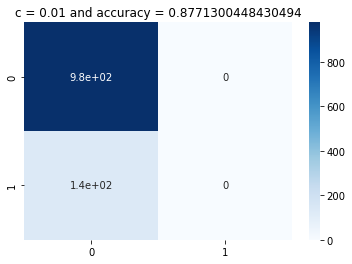

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM poly kernel with degree 5 for C value 0.1


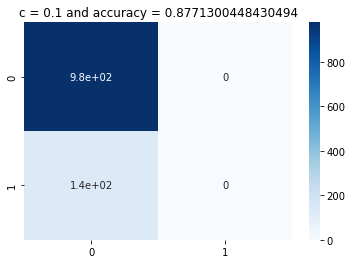

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM poly kernel with degree 5 for C value 1


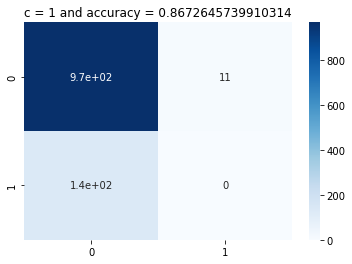

The error rate is 0.1327354260089686, accuracy is 0.8672645739910314 for c = 1
Executing SVM poly kernel with degree 5 for C value 10


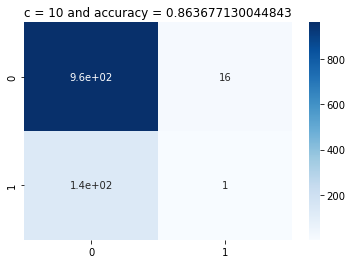

The error rate is 0.13632286995515697, accuracy is 0.863677130044843 for c = 10
Executing SVM poly kernel with degree 5 for C value 100


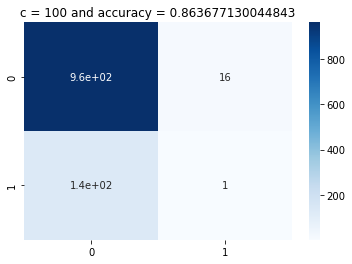

The error rate is 0.13632286995515697, accuracy is 0.863677130044843 for c = 100


In [45]:
# Executing SVM with Poly kernel and degree 5

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 5 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train, y_train, X_test, y_test, "poly", 5)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 10 for C value 0.0001


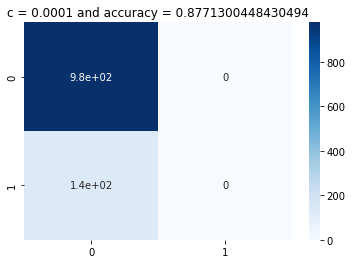

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM poly kernel with degree 10 for C value 0.001


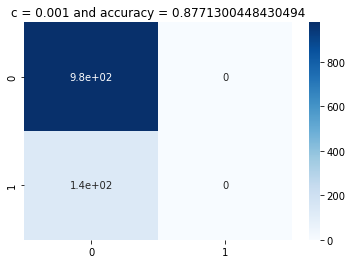

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM poly kernel with degree 10 for C value 0.01


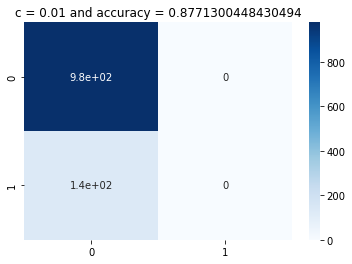

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM poly kernel with degree 10 for C value 0.1


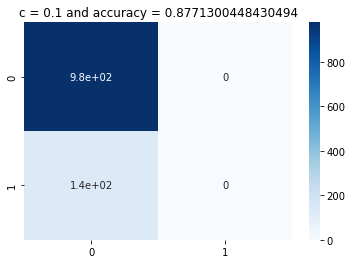

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM poly kernel with degree 10 for C value 1


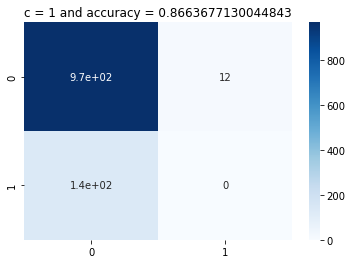

The error rate is 0.13363228699551566, accuracy is 0.8663677130044843 for c = 1
Executing SVM poly kernel with degree 10 for C value 10


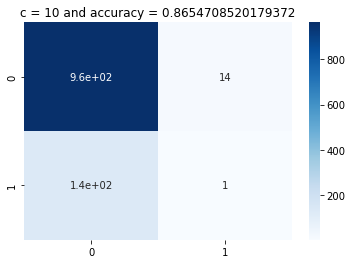

The error rate is 0.13452914798206284, accuracy is 0.8654708520179372 for c = 10
Executing SVM poly kernel with degree 10 for C value 100


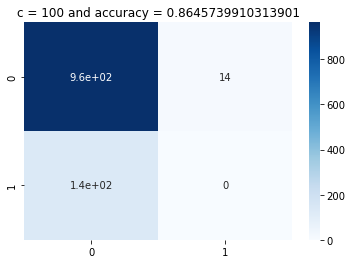

The error rate is 0.1354260089686099, accuracy is 0.8645739910313901 for c = 100


In [46]:
# Executing SVM with Poly kernel and degree 10

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 10 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train, y_train, X_test, y_test, "poly", 10)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

# Neural Networks

In [47]:
# Computing the neural network

def neuralNetwork(c, x, y, xt, yt, layers):

    if layers == "3":
        nn = MLPClassifier(hidden_layer_sizes=(128, 128, 64), alpha=c)
    elif layers == "4":
        nn = MLPClassifier(hidden_layer_sizes=(128, 128, 64, 32), alpha=c)
    elif layers == "5":
        nn = MLPClassifier(hidden_layer_sizes=(128, 128, 64, 64, 32), alpha=c)
    else:
        print(" You cannot choose more than 4 layers for this exercise")

    model_nn = nn.fit(x, y)
    ypred = model_nn.predict(xt)
    accuracy = accuracy_score(yt, ypred)
    error_rate = 1 - accuracy
    confusion_matrix_nn = confusion_matrix(yt, ypred)
    pred_prob = nn.predict_proba(xt)
    confusionmatrix_heatmap(confusion_matrix_nn, c, accuracy)

    return ypred, pred_prob, nn, error_rate

Executing Neural Networks for C value 0.0001


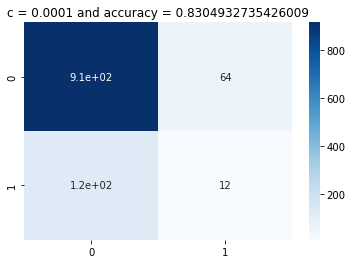

The error rate is 0.16950672645739906, accuracy is 0.8304932735426009 for c = 0.0001
Executing Neural Networks for C value 0.001


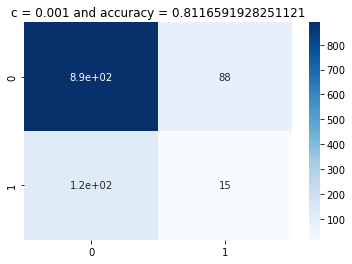

The error rate is 0.18834080717488788, accuracy is 0.8116591928251121 for c = 0.001
Executing Neural Networks for C value 0.01


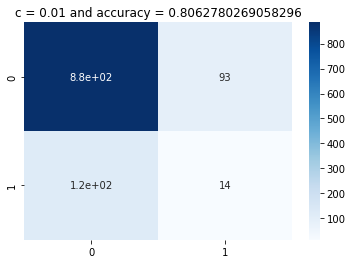

The error rate is 0.19372197309417039, accuracy is 0.8062780269058296 for c = 0.01
Executing Neural Networks for C value 0.1


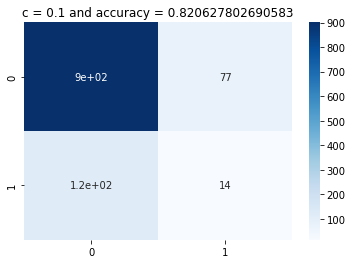

The error rate is 0.179372197309417, accuracy is 0.820627802690583 for c = 0.1
Executing Neural Networks for C value 1


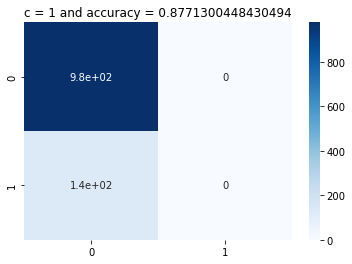

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing Neural Networks for C value 10


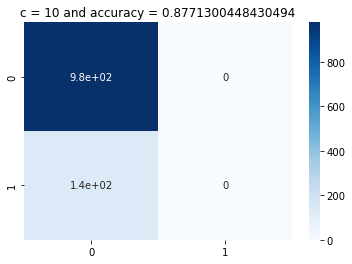

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing Neural Networks for C value 100


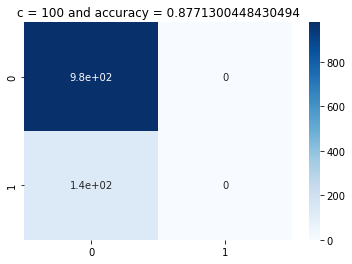

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 100


In [48]:
# Executing Neural Networks 3 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train, y_train, X_test, y_test, "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


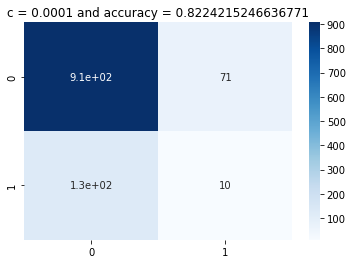

The error rate is 0.17757847533632287, accuracy is 0.8224215246636771 for c = 0.0001
Executing Neural Networks for C value 0.001


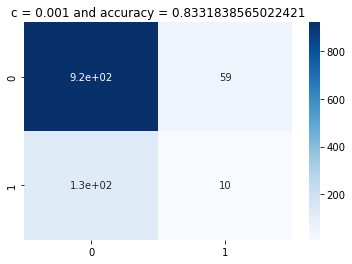

The error rate is 0.16681614349775786, accuracy is 0.8331838565022421 for c = 0.001
Executing Neural Networks for C value 0.01


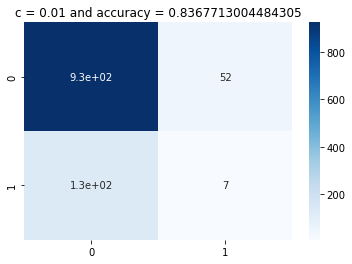

The error rate is 0.1632286995515695, accuracy is 0.8367713004484305 for c = 0.01
Executing Neural Networks for C value 0.1


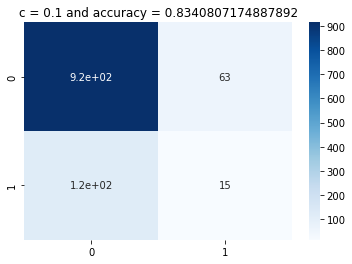

The error rate is 0.1659192825112108, accuracy is 0.8340807174887892 for c = 0.1
Executing Neural Networks for C value 1


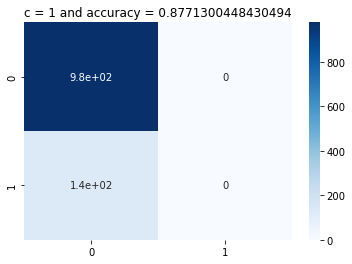

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing Neural Networks for C value 10


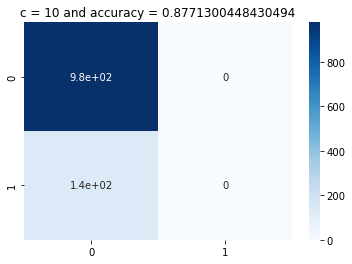

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing Neural Networks for C value 100


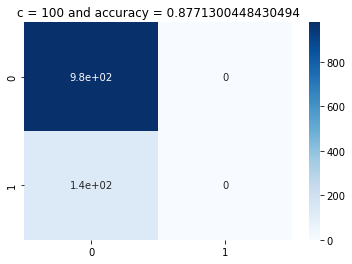

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 100


In [49]:
# Executing Neural Networks 4 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train, y_train, X_test, y_test, "4")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


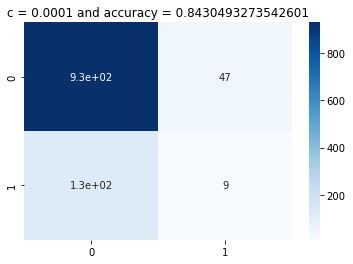

The error rate is 0.15695067264573992, accuracy is 0.8430493273542601 for c = 0.0001
Executing Neural Networks for C value 0.001


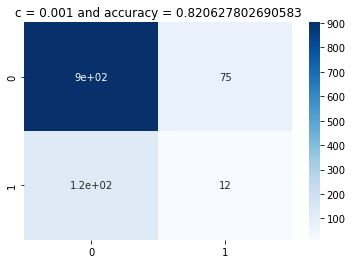

The error rate is 0.179372197309417, accuracy is 0.820627802690583 for c = 0.001
Executing Neural Networks for C value 0.01


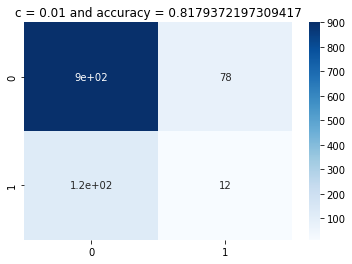

The error rate is 0.1820627802690583, accuracy is 0.8179372197309417 for c = 0.01
Executing Neural Networks for C value 0.1


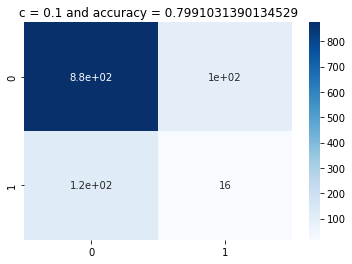

The error rate is 0.20089686098654713, accuracy is 0.7991031390134529 for c = 0.1
Executing Neural Networks for C value 1


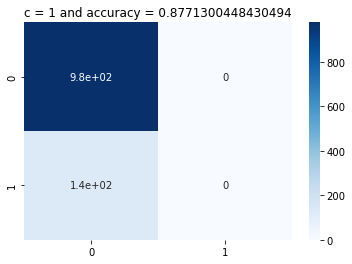

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing Neural Networks for C value 10


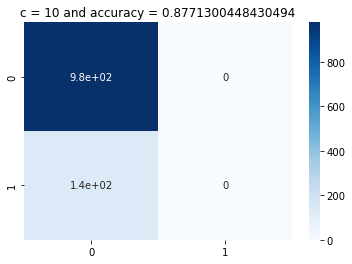

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing Neural Networks for C value 100


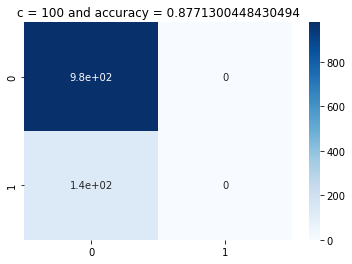

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 100


In [50]:
# Executing Neural Networks 5 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train, y_train, X_test, y_test, "5")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

# Model Implementation with CountVector transformation

## Naive Bayes with Normal Distribution

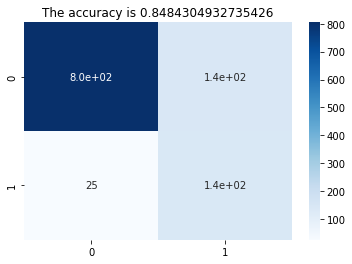

Normal distribution Naive Bayes model accuracy = 0.8484304932735426, error rate = 0.15156950672645741

Normal distribution confusion Matrix: 
[[805 144]
 [ 25 141]]

Normal distribution classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       949
           1       0.49      0.85      0.63       166

    accuracy                           0.85      1115
   macro avg       0.73      0.85      0.77      1115
weighted avg       0.90      0.85      0.86      1115




In [51]:
#Computing NaiveBayes with Normal Distribution

pred_y, prob_pred = naiveBayes(X_train_cv, y_train_cv, X_test_cv, y_test_cv, "Normal")

## Naive Bayes with Mutinomial Distribution

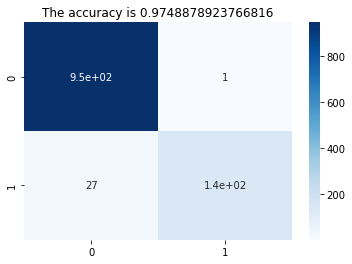

Multinomial distribution Naive Bayes model accuracy = 0.9748878923766816, error rate = 0.02511210762331839

Multinomial distribution confusion Matrix: 
[[948   1]
 [ 27 139]]

Multinomial distribution classification Report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       949
           1       0.99      0.84      0.91       166

    accuracy                           0.97      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.97      0.97      1115




In [52]:
#Computing NaiveBayes with Multinomial Distribution

pred_y, prob_pred = naiveBayes(X_train_cv, y_train_cv, X_test_cv, y_test_cv, "Multinomial")

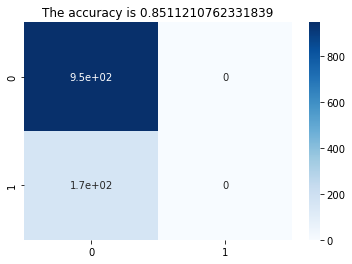

Categorical Naive Bayes model accuracy = 0.8511210762331839, error rate = 0.1488789237668161

Categorical distribution confusion Matrix: 
[[949   0]
 [166   0]]

Categorical distribution classification Report: 
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       949
           1       0.00      0.00      0.00       166

    accuracy                           0.85      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.72      0.85      0.78      1115




C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
#Computing Naivebayes with Categorical Distribution

nBc = CategoricalNB(min_categories = 2)
nBc.fit(X_train_cv, y_train_cv)
ypred_Cd = nBc.predict(X_test_cv)
accuracy = accuracy_score(y_test_cv, ypred_Cd)
error_rate = 1 - accuracy
mse = mean_squared_error(y_test_cv, ypred_Cd)
confusionMatrix = confusion_matrix(y_test_cv, ypred_Cd)
confusionmatrix_heatmap_NB_RF(confusionMatrix,accuracy)
# sensitivity =  confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
pred_prob = nBc.predict_proba(X_test_cv)
classificationReport = classification_report(y_test_cv, ypred_Cd)
print("Categorical Naive Bayes model accuracy = {}, error rate = {}\n".format(accuracy, error_rate))
print("Categorical distribution confusion Matrix: \n{}\n".format(confusionMatrix))
print("Categorical distribution classification Report: \n{}\n".format(classificationReport))

# KNN

In [54]:
#Computing KNN classifier

gridSearch_cls(X_train_cv, y_train_cv)

GridSearch K-nearest neighbors best fit k value: {'n_neighbors': 1} 


In [55]:
#Computing Cross Val Score

cvs_cls(X_train_cv, y_train_cv)

CV score [0.94282511 0.9529148  0.95847363 0.94163861 0.95286195] for K-value 1
CV score [0.87443946 0.88340807 0.87766554 0.88103255 0.88103255] for K-value 11
CV score [0.86995516 0.86883408 0.8698092  0.87093154 0.8698092 ] for K-value 21
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 31
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 41
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 51
CV score [0.87892377 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 61
CV score [0.88340807 0.86883408 0.87654321 0.87429854 0.87991021] for K-value 71
CV score [0.88452915 0.87443946 0.88776655 0.88103255 0.88888889] for K-value 81
CV score [0.89013453 0.882287   0.89337823 0.88776655 0.89113356] for K-value 91
CV score [0.89573991 0.88789238 0.89450056 0.88888889 0.90123457] for K-value 101
CV score [0.89686099 0.89573991 0.89786756 0.89337823 0.90460157] for K-value 111
CV score [0.89237668 0.8968

accuracy is 0.9533632286995516 for k = 1
accuracy is 0.8834080717488789 for k = 11
accuracy is 0.8538116591928251 for k = 21
accuracy is 0.852017937219731 for k = 31
accuracy is 0.8511210762331839 for k = 41
accuracy is 0.8511210762331839 for k = 51
accuracy is 0.8511210762331839 for k = 61
accuracy is 0.8511210762331839 for k = 71
accuracy is 0.8511210762331839 for k = 81
accuracy is 0.862780269058296 for k = 91
accuracy is 0.8690582959641255 for k = 101
accuracy is 0.874439461883408 for k = 111
accuracy is 0.8780269058295964 for k = 121
accuracy is 0.8834080717488789 for k = 131
accuracy is 0.8869955156950673 for k = 141
accuracy is 0.8887892376681614 for k = 151
accuracy is 0.8896860986547085 for k = 161
accuracy is 0.8905829596412556 for k = 171
accuracy is 0.8887892376681614 for k = 181
accuracy is 0.8896860986547085 for k = 191
accuracy is 0.8887892376681614 for k = 201


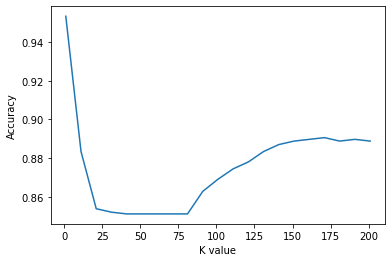

In [56]:
#Computing graph for accuracy vs k

mvk_knncls(X_train_cv, y_train_cv, X_test_cv, y_test_cv)

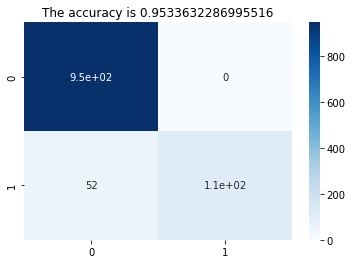

knn model accuracy = 0.9533632286995516, error rate = 0.04663677130044841

Confusion Matrix: 
[[949   0]
 [ 52 114]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       949
           1       1.00      0.69      0.81       166

    accuracy                           0.95      1115
   macro avg       0.97      0.84      0.89      1115
weighted avg       0.96      0.95      0.95      1115




In [57]:
# Predicting with best K value which is 1

model_knnCls = knn_predict(X_train_cv, y_train_cv, X_test_cv, y_test_cv,1)

# Random Forest

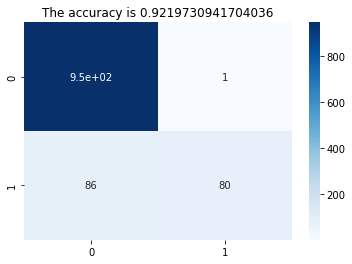

Random Forest model, accuracy is 0.9219730941704036, mse is 0.07802690582959641
Its out of bag score is 0.9423378954453668, test error is 0.07802690582959637


In [58]:
#Computing random forest on data

model_rf, predy, prob_pred = randomForest(X_train_cv, y_train_cv, X_test_cv, y_test_cv)

# SVM

Executing SVM Linear Kernel for C value 0.0001


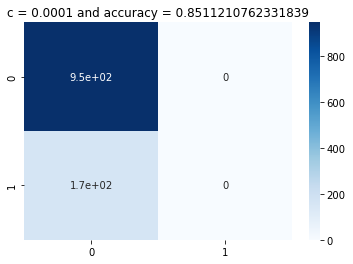

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM Linear Kernel for C value 0.001


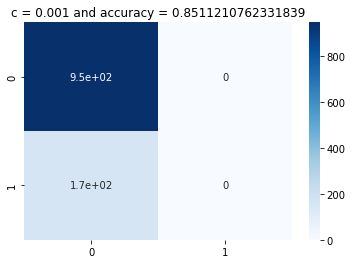

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM Linear Kernel for C value 0.01


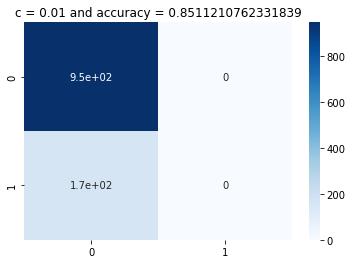

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM Linear Kernel for C value 0.1


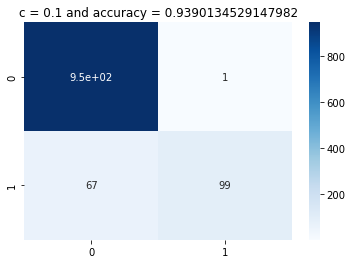

The error rate is 0.06098654708520179, accuracy is 0.9390134529147982 for c = 0.1
Executing SVM Linear Kernel for C value 1


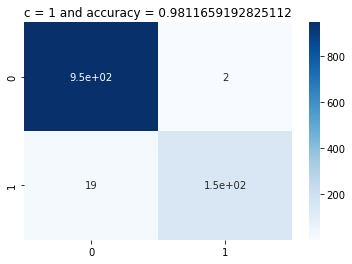

The error rate is 0.01883408071748882, accuracy is 0.9811659192825112 for c = 1
Executing SVM Linear Kernel for C value 10


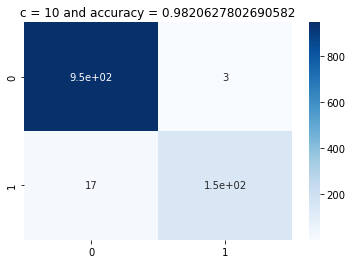

The error rate is 0.017937219730941756, accuracy is 0.9820627802690582 for c = 10
Executing SVM Linear Kernel for C value 100


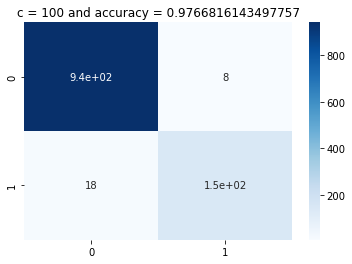

The error rate is 0.02331838565022426, accuracy is 0.9766816143497757 for c = 100


In [59]:
# Executing SVM with linear kernel

for c in reg_parameters:
    print("Executing SVM Linear Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "linear", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM RBF Kernel for C value 0.0001


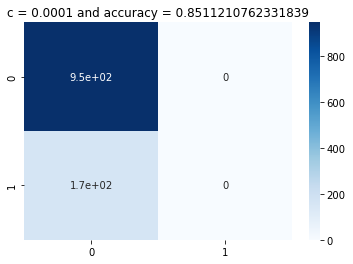

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM RBF Kernel for C value 0.001


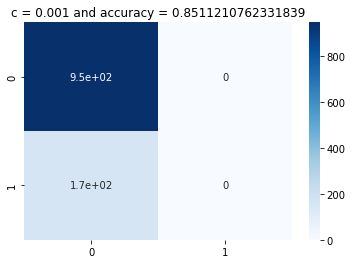

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM RBF Kernel for C value 0.01


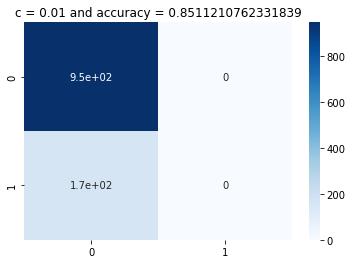

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM RBF Kernel for C value 0.1


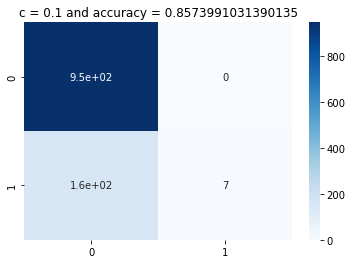

The error rate is 0.14260089686098654, accuracy is 0.8573991031390135 for c = 0.1
Executing SVM RBF Kernel for C value 1


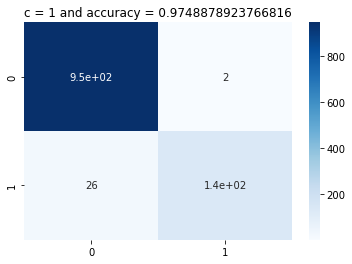

The error rate is 0.02511210762331839, accuracy is 0.9748878923766816 for c = 1
Executing SVM RBF Kernel for C value 10


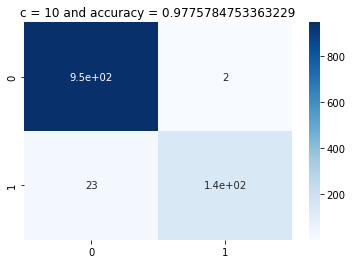

The error rate is 0.022421524663677084, accuracy is 0.9775784753363229 for c = 10
Executing SVM RBF Kernel for C value 100


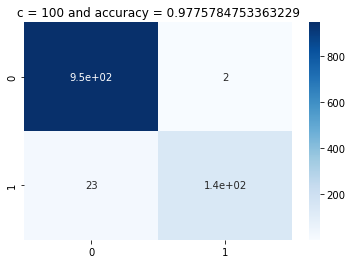

The error rate is 0.022421524663677084, accuracy is 0.9775784753363229 for c = 100


In [60]:
# Executing SVM with RBF kernel

for c in reg_parameters:
    print("Executing SVM RBF Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "rbf", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM Poly Kernel with degree 3 for C value 0.0001


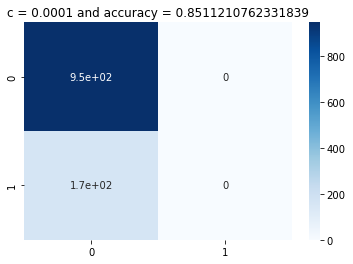

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM Poly Kernel with degree 3 for C value 0.001


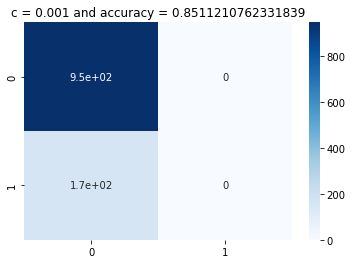

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM Poly Kernel with degree 3 for C value 0.01


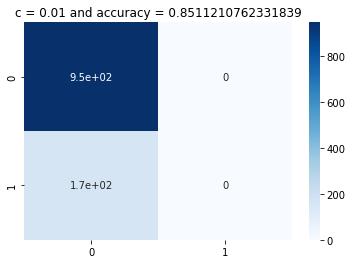

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM Poly Kernel with degree 3 for C value 0.1


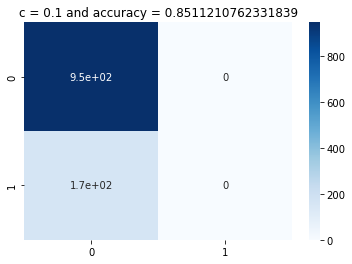

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM Poly Kernel with degree 3 for C value 1


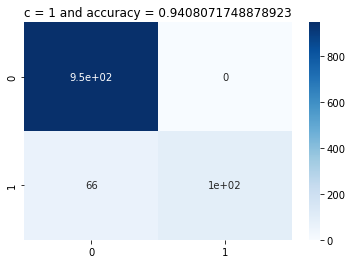

The error rate is 0.05919282511210766, accuracy is 0.9408071748878923 for c = 1
Executing SVM Poly Kernel with degree 3 for C value 10


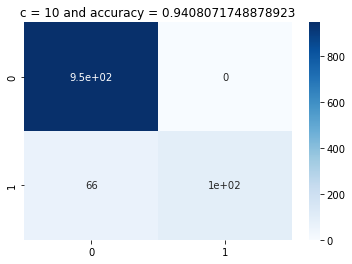

The error rate is 0.05919282511210766, accuracy is 0.9408071748878923 for c = 10
Executing SVM Poly Kernel with degree 3 for C value 100


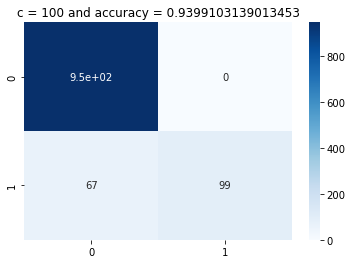

The error rate is 0.06008968609865473, accuracy is 0.9399103139013453 for c = 100


In [61]:
# Executing SVM with Poly kernel and degree 3

for c in reg_parameters:
    print("Executing SVM Poly Kernel with degree 3 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "poly", 3)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 5 for C value 0.0001


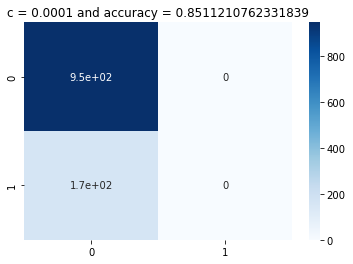

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM poly kernel with degree 5 for C value 0.001


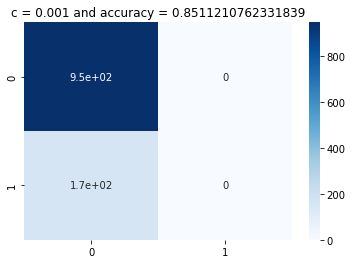

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM poly kernel with degree 5 for C value 0.01


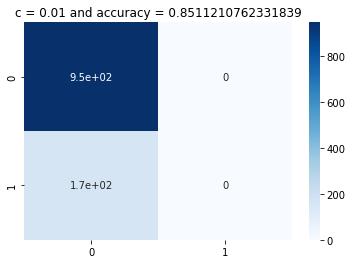

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM poly kernel with degree 5 for C value 0.1


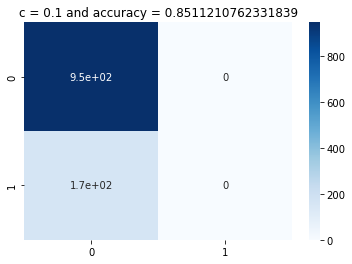

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM poly kernel with degree 5 for C value 1


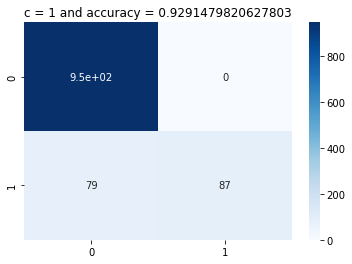

The error rate is 0.07085201793721974, accuracy is 0.9291479820627803 for c = 1
Executing SVM poly kernel with degree 5 for C value 10


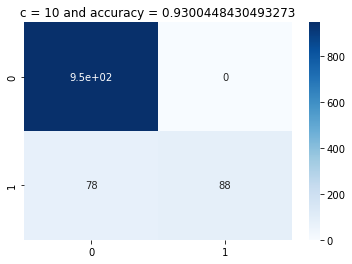

The error rate is 0.06995515695067267, accuracy is 0.9300448430493273 for c = 10
Executing SVM poly kernel with degree 5 for C value 100


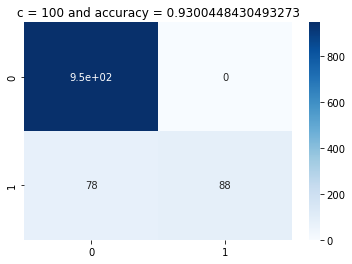

The error rate is 0.06995515695067267, accuracy is 0.9300448430493273 for c = 100


In [62]:
# Executing SVM with Poly kernel and degree 5

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 5 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "poly", 5)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 10 for C value 0.0001


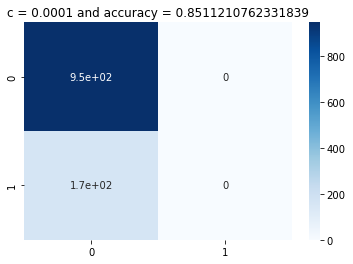

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM poly kernel with degree 10 for C value 0.001


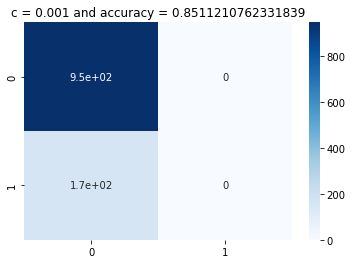

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM poly kernel with degree 10 for C value 0.01


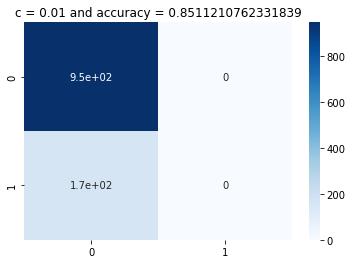

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM poly kernel with degree 10 for C value 0.1


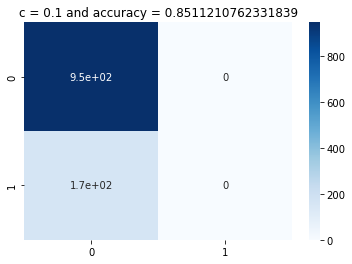

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM poly kernel with degree 10 for C value 1


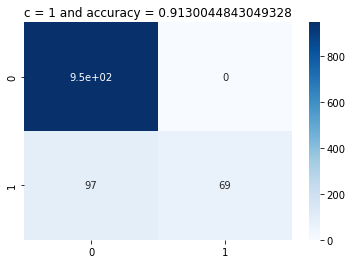

The error rate is 0.08699551569506725, accuracy is 0.9130044843049328 for c = 1
Executing SVM poly kernel with degree 10 for C value 10


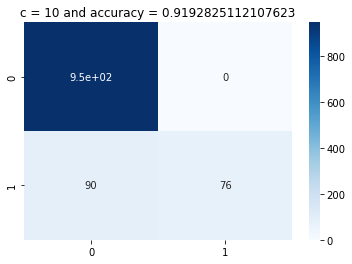

The error rate is 0.08071748878923768, accuracy is 0.9192825112107623 for c = 10
Executing SVM poly kernel with degree 10 for C value 100


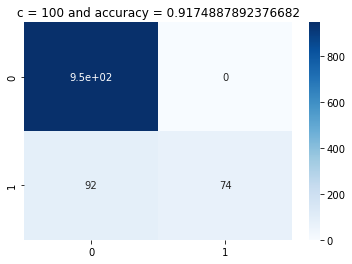

The error rate is 0.08251121076233181, accuracy is 0.9174887892376682 for c = 100


In [63]:
# Executing SVM with Poly kernel and degree 10

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 10 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "poly", 10)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

# Neural Networks

Executing Neural Networks for C value 0.0001


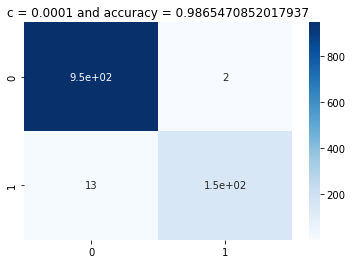

The error rate is 0.013452914798206317, accuracy is 0.9865470852017937 for c = 0.0001
Executing Neural Networks for C value 0.001


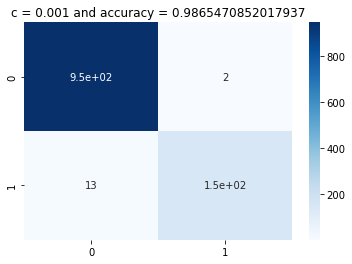

The error rate is 0.013452914798206317, accuracy is 0.9865470852017937 for c = 0.001
Executing Neural Networks for C value 0.01


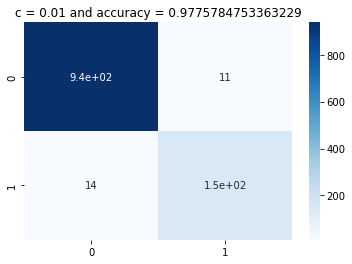

The error rate is 0.022421524663677084, accuracy is 0.9775784753363229 for c = 0.01
Executing Neural Networks for C value 0.1


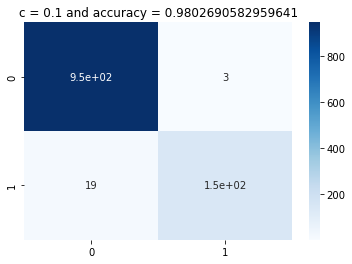

The error rate is 0.019730941704035887, accuracy is 0.9802690582959641 for c = 0.1
Executing Neural Networks for C value 1


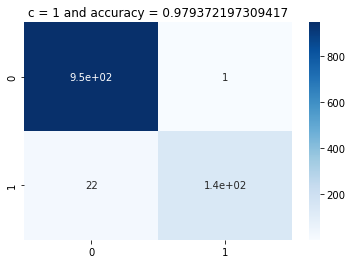

The error rate is 0.020627802690582953, accuracy is 0.979372197309417 for c = 1
Executing Neural Networks for C value 10


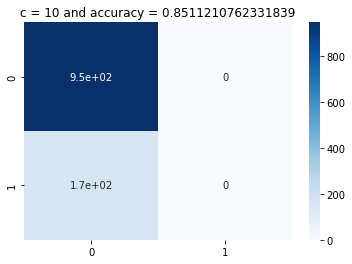

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing Neural Networks for C value 100


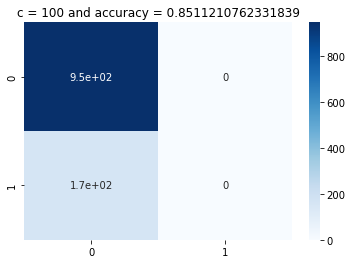

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 100


In [64]:
# Executing Neural Networks 3 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1 - error, c))

Executing Neural Networks for C value 0.0001


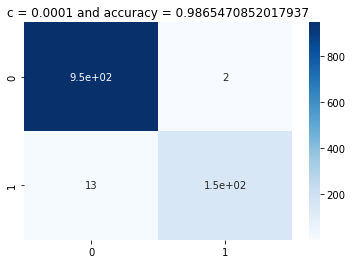

The error rate is 0.013452914798206317, accuracy is 0.9865470852017937 for c = 0.0001
Executing Neural Networks for C value 0.001


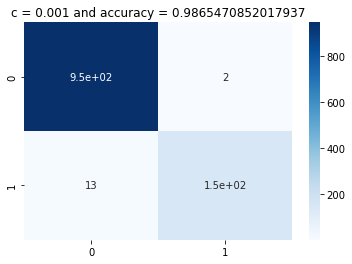

The error rate is 0.013452914798206317, accuracy is 0.9865470852017937 for c = 0.001
Executing Neural Networks for C value 0.01


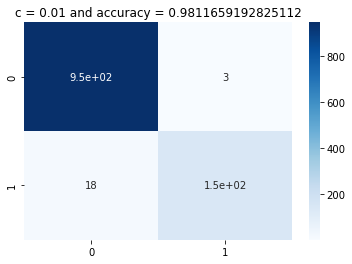

The error rate is 0.01883408071748882, accuracy is 0.9811659192825112 for c = 0.01
Executing Neural Networks for C value 0.1


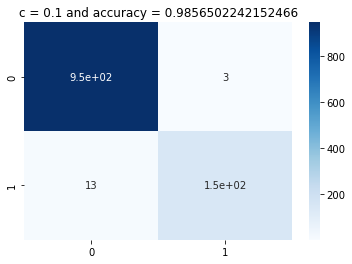

The error rate is 0.014349775784753382, accuracy is 0.9856502242152466 for c = 0.1
Executing Neural Networks for C value 1


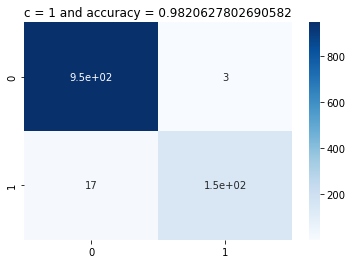

The error rate is 0.017937219730941756, accuracy is 0.9820627802690582 for c = 1
Executing Neural Networks for C value 10


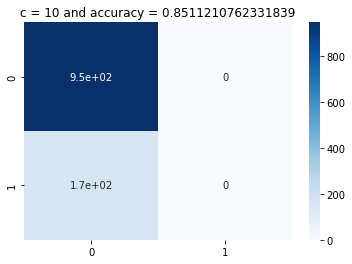

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing Neural Networks for C value 100


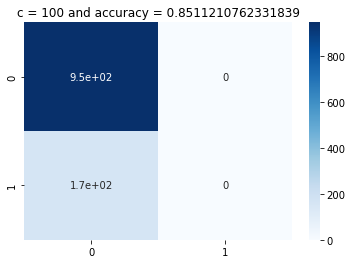

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 100


In [65]:
# Executing Neural Networks 4 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "4")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


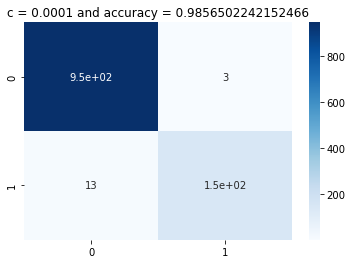

The error rate is 0.014349775784753382, accuracy is 0.9856502242152466 for c = 0.0001
Executing Neural Networks for C value 0.001


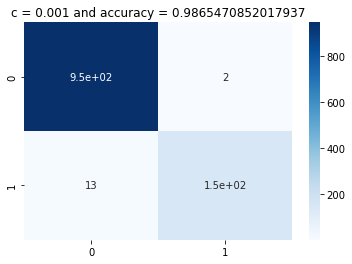

The error rate is 0.013452914798206317, accuracy is 0.9865470852017937 for c = 0.001
Executing Neural Networks for C value 0.01


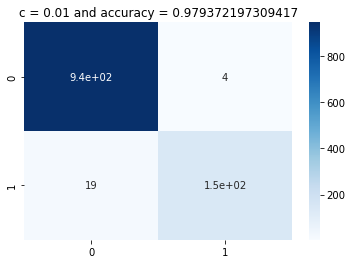

The error rate is 0.020627802690582953, accuracy is 0.979372197309417 for c = 0.01
Executing Neural Networks for C value 0.1


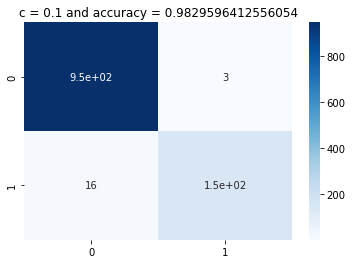

The error rate is 0.01704035874439458, accuracy is 0.9829596412556054 for c = 0.1
Executing Neural Networks for C value 1


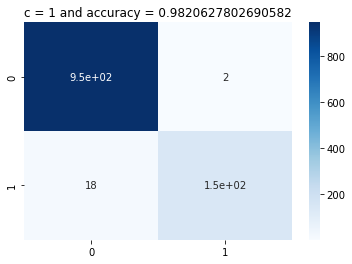

The error rate is 0.017937219730941756, accuracy is 0.9820627802690582 for c = 1
Executing Neural Networks for C value 10


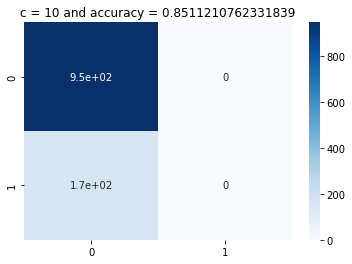

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing Neural Networks for C value 100


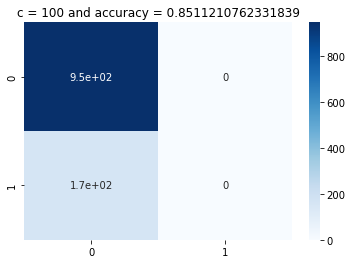

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 100


In [66]:
# Executing Neural Networks 5 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "5")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Logistic Regression (L2), for C value 0.0001


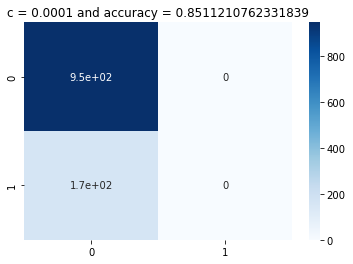

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing Logistic Regression (L2), for C value 0.001


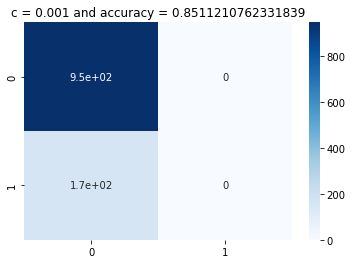

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing Logistic Regression (L2), for C value 0.01


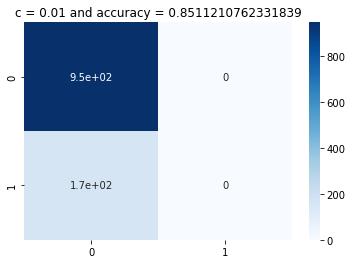

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing Logistic Regression (L2), for C value 0.1


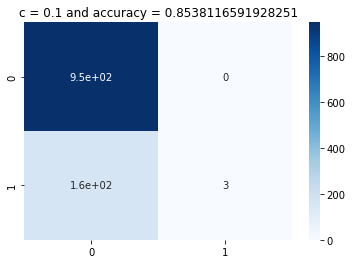

The error rate is 0.1461883408071749, accuracy is 0.8538116591928251 for c = 0.1
Executing Logistic Regression (L2), for C value 1


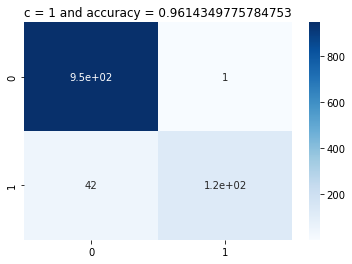

The error rate is 0.03856502242152471, accuracy is 0.9614349775784753 for c = 1
Executing Logistic Regression (L2), for C value 10


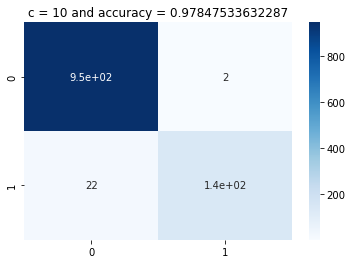

The error rate is 0.021524663677130018, accuracy is 0.97847533632287 for c = 10
Executing Logistic Regression (L2), for C value 100


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


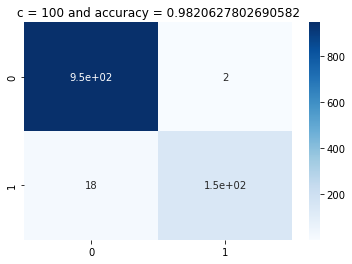

The error rate is 0.017937219730941756, accuracy is 0.9820627802690582 for c = 100


In [67]:
# Executing logistic regression function with l2 regularization and solver SAG

for c in reg_parameters:
    print("Executing Logistic Regression (L2), for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = logistic_regression(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "l2 reg")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))
    # pred_y, prob_pred, reg_fit, error = logistic_regression(c, X_train, y_train, X_test, y_test, "l2 reg")

Executing Logistic Regression (L1), for C value 0.0001
reg is l1


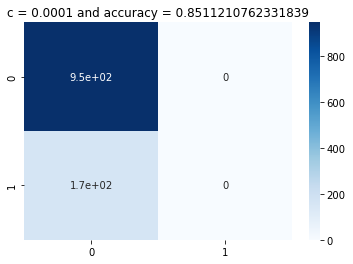

Executing Logistic Regression (L1), for C value 0.001
reg is l1


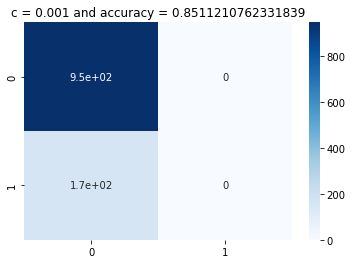

Executing Logistic Regression (L1), for C value 0.01
reg is l1


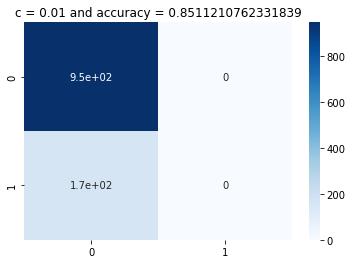

Executing Logistic Regression (L1), for C value 0.1
reg is l1


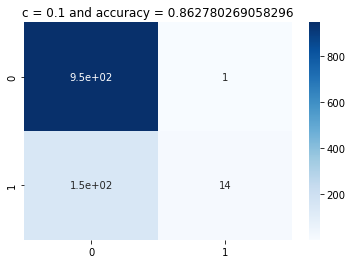

Executing Logistic Regression (L1), for C value 1
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


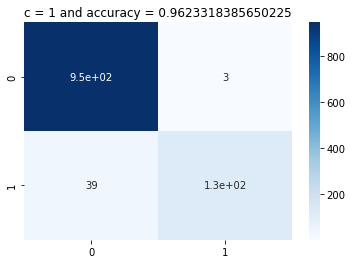

Executing Logistic Regression (L1), for C value 10
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


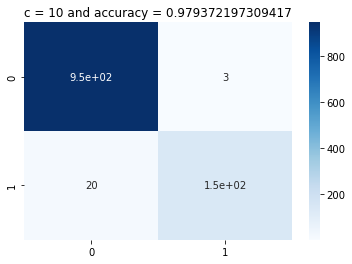

Executing Logistic Regression (L1), for C value 100
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


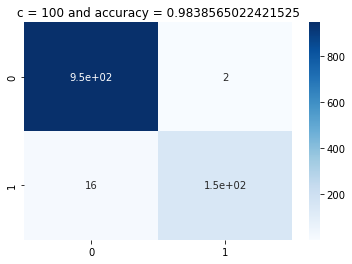

In [68]:
# Executing Logistic regression with l1 regularization and solver SAGA

for c in reg_parameters:
    print("Executing Logistic Regression (L1), for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = logistic_regression(c, X_train_cv, y_train_cv, X_test_cv, y_test_cv, "l1 reg")

# Word2Vec vectorization implementation of Naive Bayes, Logistic Regression, SVM, Neural Networks, Random Forest and KNN

## Naive Bayes

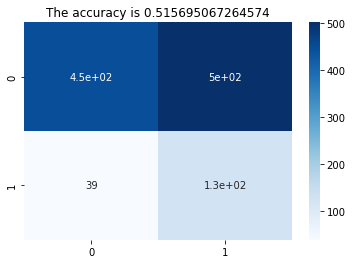

Normal distribution Naive Bayes model accuracy = 0.515695067264574, error rate = 0.48430493273542596

Normal distribution confusion Matrix: 
[[448 501]
 [ 39 127]]

Normal distribution classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.47      0.62       949
           1       0.20      0.77      0.32       166

    accuracy                           0.52      1115
   macro avg       0.56      0.62      0.47      1115
weighted avg       0.81      0.52      0.58      1115




In [69]:
#Computing NaiveBayes with Normal Distribution

pred_y, prob_pred = naiveBayes(wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "Normal")

# KNN

In [70]:
#Computing KNN classifier

gridSearch_cls(wordVecTrain, y_train_w2v)

GridSearch K-nearest neighbors best fit k value: {'n_neighbors': 11} 


In [71]:
#Computing Cross Val Score

cvs_cls(wordVecTrain, y_train_w2v)

CV score [0.94955157 0.92264574 0.93378227 0.93602694 0.93602694] for K-value 1
CV score [0.95403587 0.94506726 0.95061728 0.94276094 0.95959596] for K-value 11
CV score [0.93049327 0.93273543 0.93378227 0.93378227 0.9349046 ] for K-value 21
CV score [0.89798206 0.90358744 0.9023569  0.90796857 0.90460157] for K-value 31
CV score [0.88565022 0.88452915 0.88215488 0.88664422 0.89113356] for K-value 41
CV score [0.87892377 0.87780269 0.87317621 0.87654321 0.87878788] for K-value 51
CV score [0.87219731 0.86883408 0.87205387 0.87093154 0.87093154] for K-value 61
CV score [0.86995516 0.86883408 0.87093154 0.8698092  0.8698092 ] for K-value 71
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 81
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 91
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 101
CV score [0.86995516 0.86883408 0.8698092  0.8698092  0.8698092 ] for K-value 111
CV score [0.86995516 0.8688

accuracy is 0.9426008968609866 for k = 1
accuracy is 0.9381165919282511 for k = 11
accuracy is 0.9219730941704036 for k = 21
accuracy is 0.9004484304932735 for k = 31
accuracy is 0.8816143497757848 for k = 41
accuracy is 0.8672645739910314 for k = 51
accuracy is 0.8582959641255605 for k = 61
accuracy is 0.852017937219731 for k = 71
accuracy is 0.8511210762331839 for k = 81
accuracy is 0.8511210762331839 for k = 91
accuracy is 0.8511210762331839 for k = 101
accuracy is 0.8511210762331839 for k = 111
accuracy is 0.8511210762331839 for k = 121
accuracy is 0.8511210762331839 for k = 131
accuracy is 0.8511210762331839 for k = 141
accuracy is 0.8511210762331839 for k = 151
accuracy is 0.8511210762331839 for k = 161
accuracy is 0.8511210762331839 for k = 171
accuracy is 0.8511210762331839 for k = 181
accuracy is 0.8511210762331839 for k = 191
accuracy is 0.8511210762331839 for k = 201


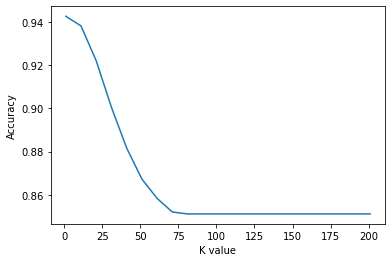

In [72]:
#Computing graph for accuracy vs k

mvk_knncls(wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v)

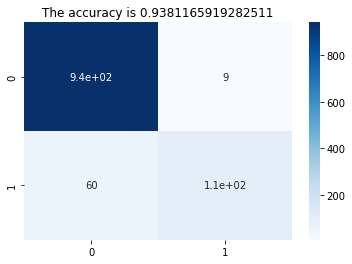

knn model accuracy = 0.9381165919282511, error rate = 0.06188340807174886

Confusion Matrix: 
[[940   9]
 [ 60 106]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       949
           1       0.92      0.64      0.75       166

    accuracy                           0.94      1115
   macro avg       0.93      0.81      0.86      1115
weighted avg       0.94      0.94      0.93      1115




In [73]:
# Predicting with best K value which is 11

model_knnCls = knn_predict(wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v,11)

# Random Forest

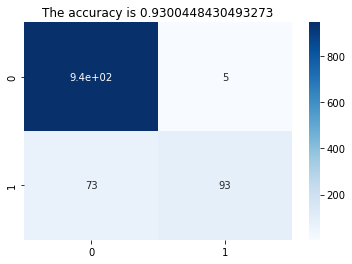

Random Forest model, accuracy is 0.9300448430493273, mse is 0.06995515695067264
Its out of bag score is 0.9483957819160871, test error is 0.06995515695067267


In [74]:
model_rf, predy, prob_pred = randomForest(wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v)

# Support Vector Machines

Executing SVM Linear Kernel for C value 0.0001


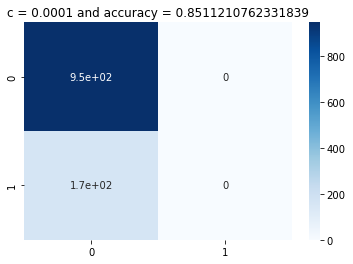

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM Linear Kernel for C value 0.001


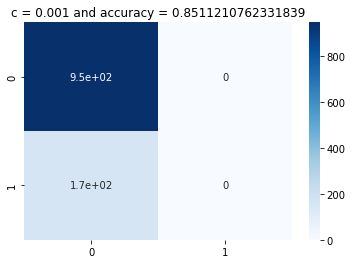

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM Linear Kernel for C value 0.01


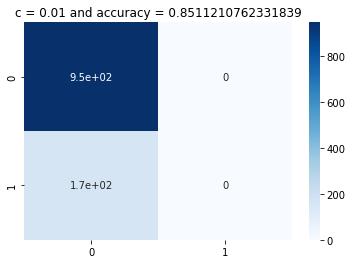

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM Linear Kernel for C value 0.1


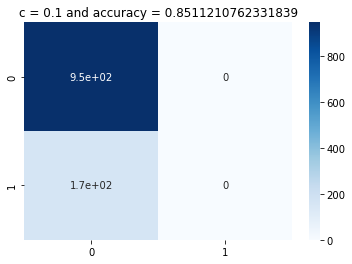

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM Linear Kernel for C value 1


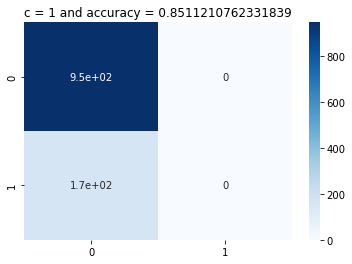

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing SVM Linear Kernel for C value 10


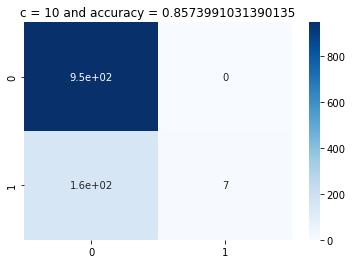

The error rate is 0.14260089686098654, accuracy is 0.8573991031390135 for c = 10
Executing SVM Linear Kernel for C value 100


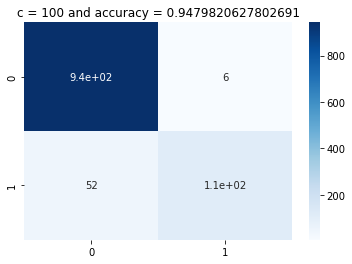

The error rate is 0.052017937219730914, accuracy is 0.9479820627802691 for c = 100


In [75]:
# Executing SVM with linear kernel

for c in reg_parameters:
    print("Executing SVM Linear Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "linear", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1 - error, c))

Executing SVM RBF Kernel for C value 0.0001


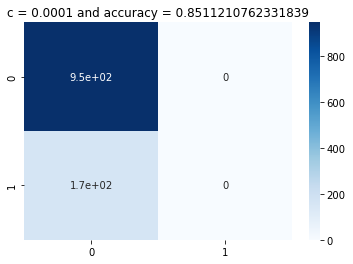

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM RBF Kernel for C value 0.001


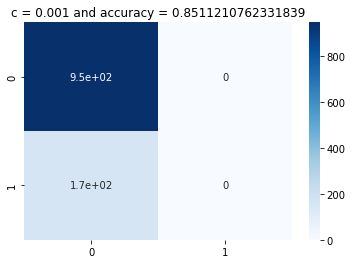

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM RBF Kernel for C value 0.01


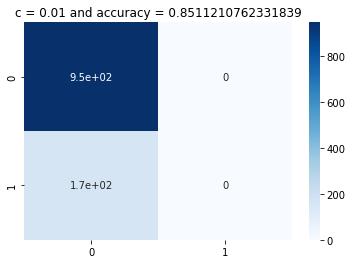

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM RBF Kernel for C value 0.1


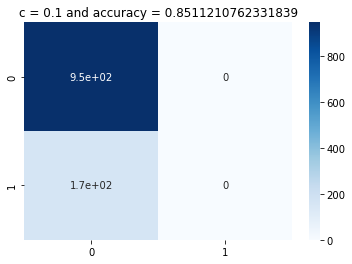

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM RBF Kernel for C value 1


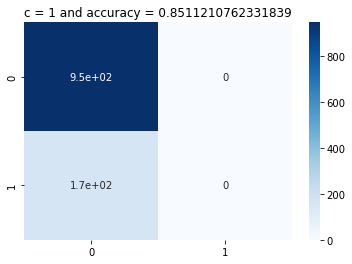

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing SVM RBF Kernel for C value 10


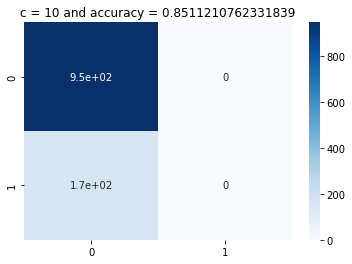

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing SVM RBF Kernel for C value 100


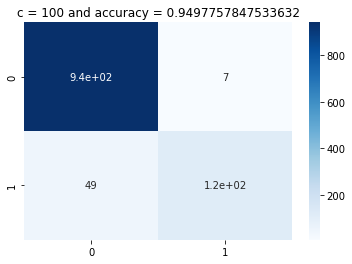

The error rate is 0.05022421524663678, accuracy is 0.9497757847533632 for c = 100


In [76]:
# Executing SVM with RBF kernel

for c in reg_parameters:
    print("Executing SVM RBF Kernel for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "rbf", "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM Poly Kernel with degree 3 for C value 0.0001


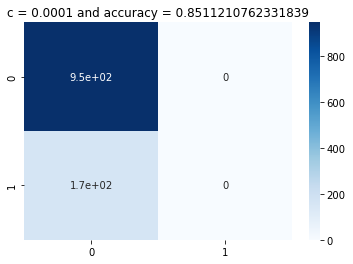

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM Poly Kernel with degree 3 for C value 0.001


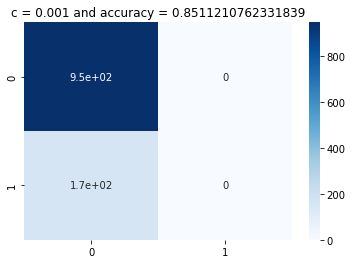

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM Poly Kernel with degree 3 for C value 0.01


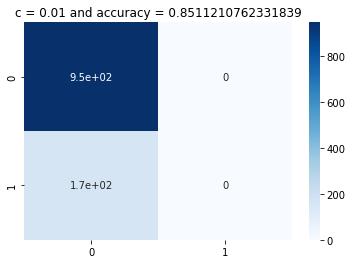

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM Poly Kernel with degree 3 for C value 0.1


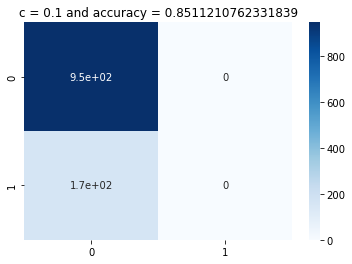

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM Poly Kernel with degree 3 for C value 1


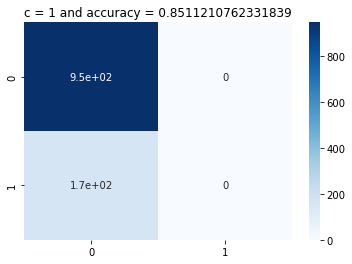

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing SVM Poly Kernel with degree 3 for C value 10


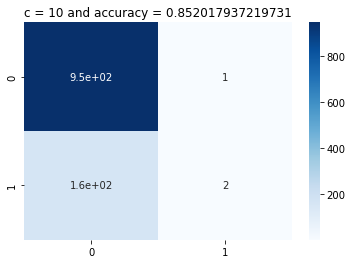

The error rate is 0.14798206278026904, accuracy is 0.852017937219731 for c = 10
Executing SVM Poly Kernel with degree 3 for C value 100


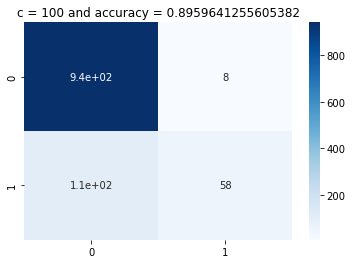

The error rate is 0.10403587443946183, accuracy is 0.8959641255605382 for c = 100


In [77]:
# Executing SVM with Poly kernel and degree 3

for c in reg_parameters:
    print("Executing SVM Poly Kernel with degree 3 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "poly", 3)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 5 for C value 0.0001


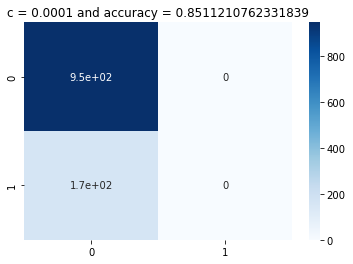

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing SVM poly kernel with degree 5 for C value 0.001


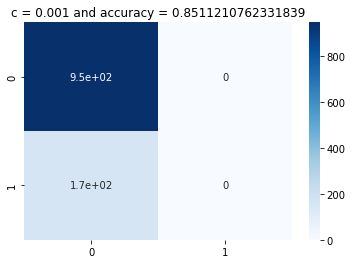

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing SVM poly kernel with degree 5 for C value 0.01


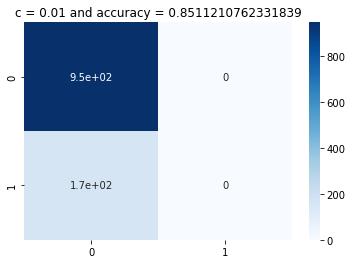

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing SVM poly kernel with degree 5 for C value 0.1


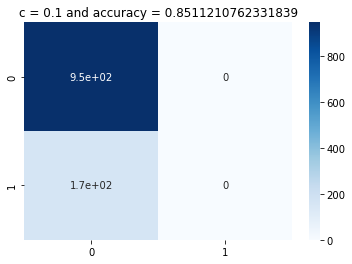

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing SVM poly kernel with degree 5 for C value 1


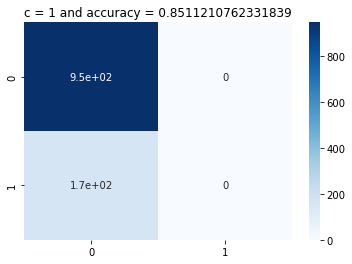

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing SVM poly kernel with degree 5 for C value 10


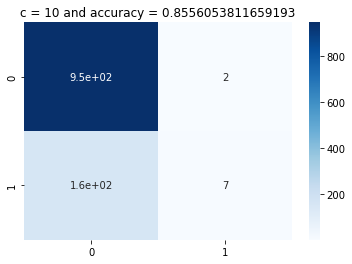

The error rate is 0.14439461883408067, accuracy is 0.8556053811659193 for c = 10
Executing SVM poly kernel with degree 5 for C value 100


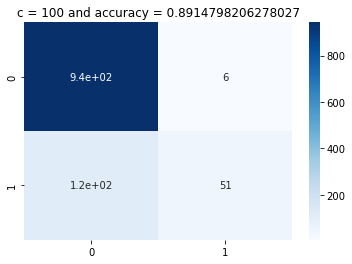

The error rate is 0.10852017937219727, accuracy is 0.8914798206278027 for c = 100


In [78]:
# Executing SVM with Poly kernel and degree 5

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 5 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "poly", 5)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing SVM poly kernel with degree 10 for C value 0.0001


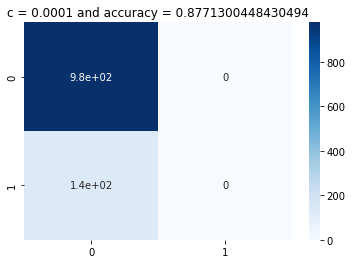

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing SVM poly kernel with degree 10 for C value 0.001


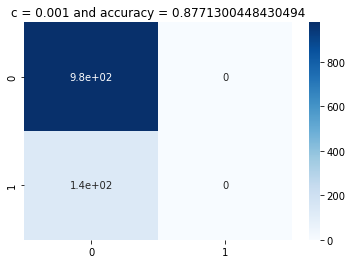

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing SVM poly kernel with degree 10 for C value 0.01


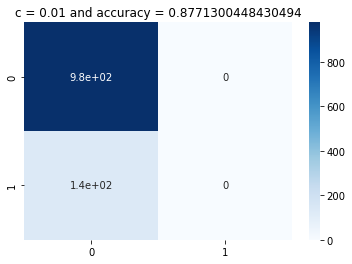

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing SVM poly kernel with degree 10 for C value 0.1


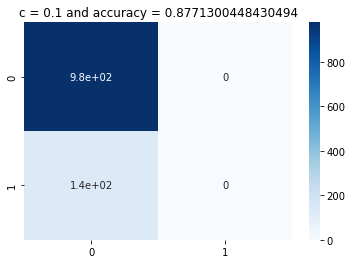

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing SVM poly kernel with degree 10 for C value 1


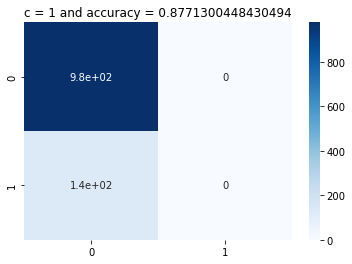

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing SVM poly kernel with degree 10 for C value 10


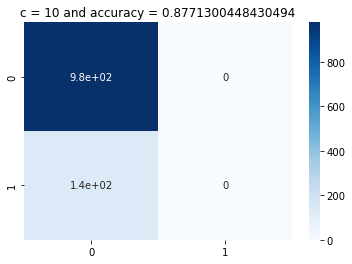

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing SVM poly kernel with degree 10 for C value 100


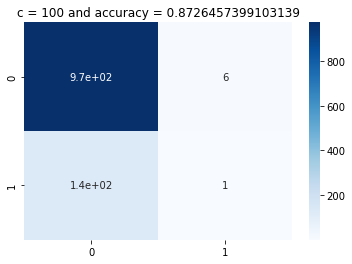

The error rate is 0.1273542600896861, accuracy is 0.8726457399103139 for c = 100


In [79]:
# Executing SVM with Poly kernel and degree 10

for c in reg_parameters:
    print("Executing SVM poly kernel with degree 10 for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = svM(c, wordVecTrain, y_train, wordVecTest, y_test, "poly", 10)
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


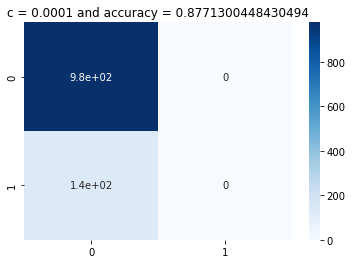

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing Neural Networks for C value 0.001


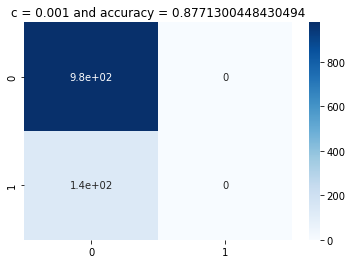

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing Neural Networks for C value 0.01


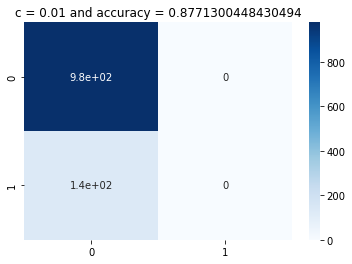

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing Neural Networks for C value 0.1


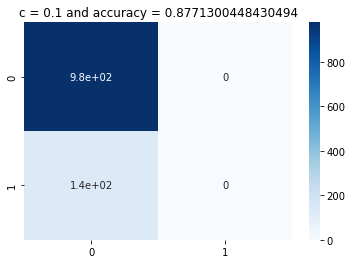

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing Neural Networks for C value 1


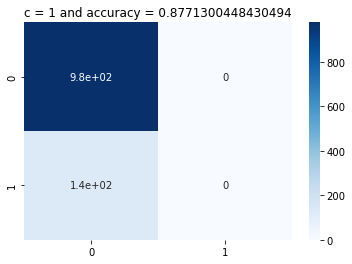

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing Neural Networks for C value 10


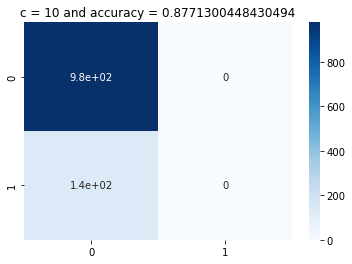

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing Neural Networks for C value 100


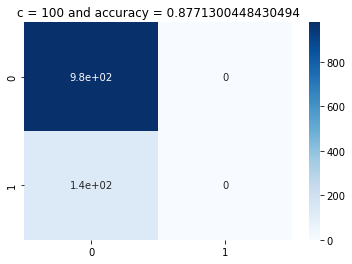

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 100


In [80]:
# Executing Neural Networks 3 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, wordVecTrain, y_train, wordVecTest, y_test, "3")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


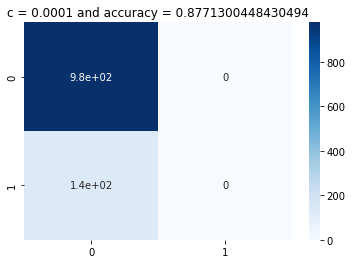

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.0001
Executing Neural Networks for C value 0.001


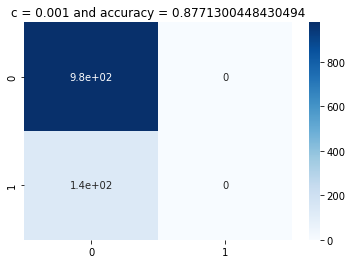

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.001
Executing Neural Networks for C value 0.01


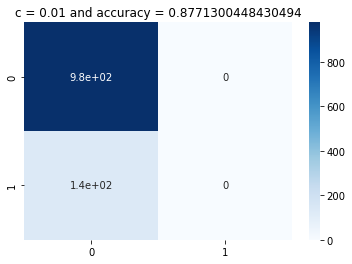

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.01
Executing Neural Networks for C value 0.1


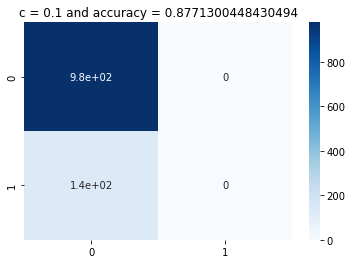

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 0.1
Executing Neural Networks for C value 1


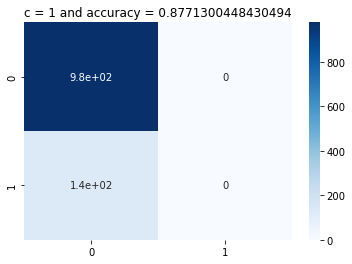

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 1
Executing Neural Networks for C value 10


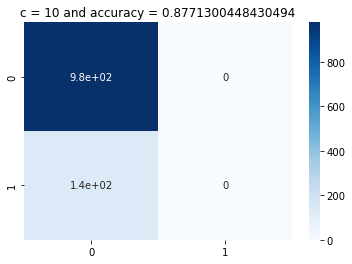

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 10
Executing Neural Networks for C value 100


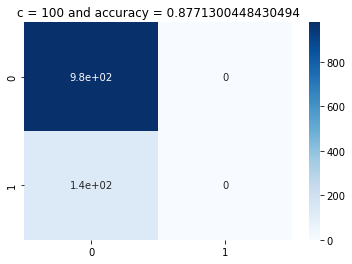

The error rate is 0.12286995515695065, accuracy is 0.8771300448430494 for c = 100


In [81]:
# Executing Neural Networks 4 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, wordVecTrain, y_train, wordVecTest, y_test, "4")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Neural Networks for C value 0.0001


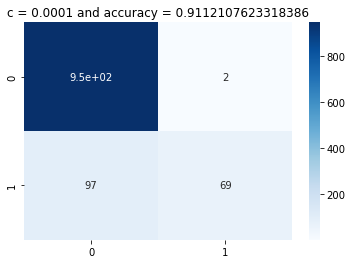

The error rate is 0.08878923766816138, accuracy is 0.9112107623318386 for c = 0.0001
Executing Neural Networks for C value 0.001


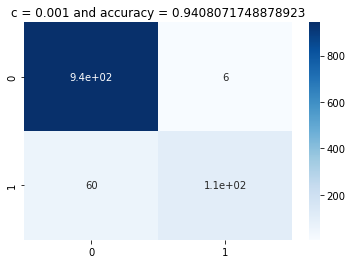

The error rate is 0.05919282511210766, accuracy is 0.9408071748878923 for c = 0.001
Executing Neural Networks for C value 0.01


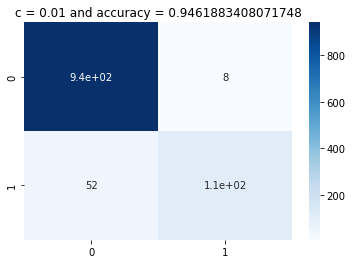

The error rate is 0.053811659192825156, accuracy is 0.9461883408071748 for c = 0.01
Executing Neural Networks for C value 0.1


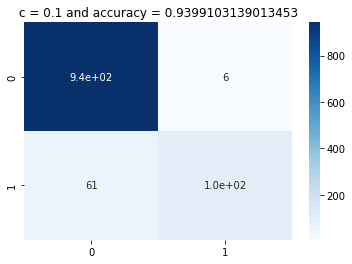

The error rate is 0.06008968609865473, accuracy is 0.9399103139013453 for c = 0.1
Executing Neural Networks for C value 1


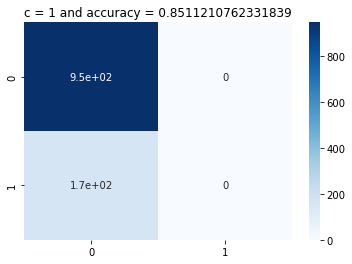

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing Neural Networks for C value 10


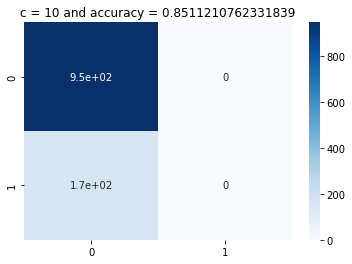

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing Neural Networks for C value 100


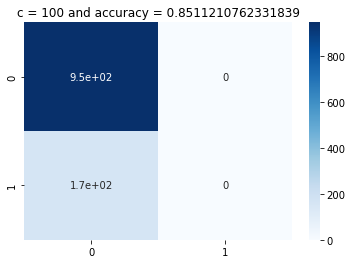

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 100


In [82]:
# Executing Neural Networks 5 layers

for c in reg_parameters:
    print("Executing Neural Networks for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = neuralNetwork(c, wordVecTrain, y_train_cv, wordVecTest, y_test_cv, "5")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Logistic Regression (L2), for C value 0.0001


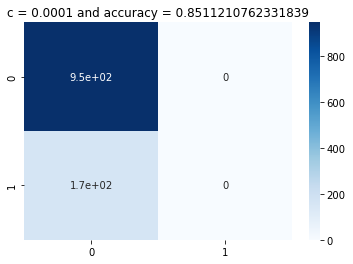

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.0001
Executing Logistic Regression (L2), for C value 0.001


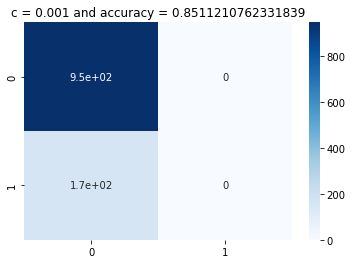

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.001
Executing Logistic Regression (L2), for C value 0.01


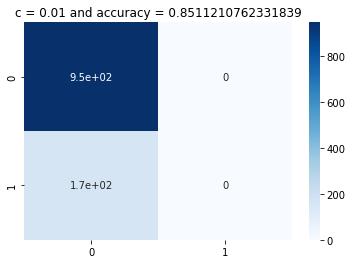

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.01
Executing Logistic Regression (L2), for C value 0.1


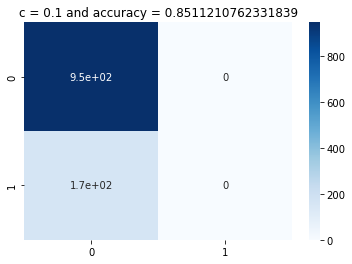

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 0.1
Executing Logistic Regression (L2), for C value 1


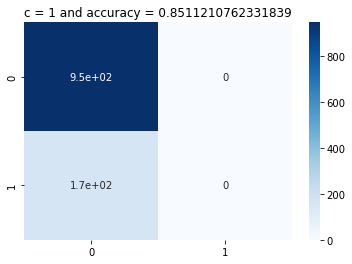

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 1
Executing Logistic Regression (L2), for C value 10


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


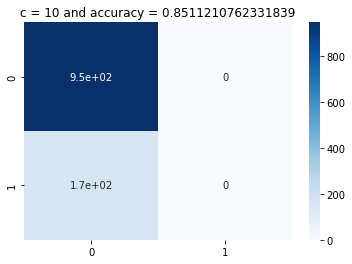

The error rate is 0.1488789237668161, accuracy is 0.8511210762331839 for c = 10
Executing Logistic Regression (L2), for C value 100


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


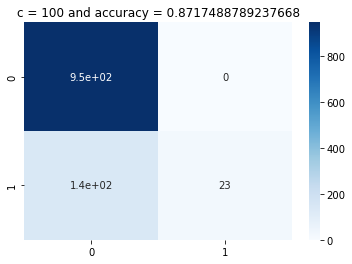

The error rate is 0.12825112107623315, accuracy is 0.8717488789237668 for c = 100


In [83]:
# Executing logistic regression function with l2 regularization and solver SAG

for c in reg_parameters:
    print("Executing Logistic Regression (L2), for C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = logistic_regression(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "l2 reg")
    print("The error rate is {}, accuracy is {} for c = {}".format(error, 1-error, c))

Executing Logistic Regression (L1), C value 0.0001
reg is l1


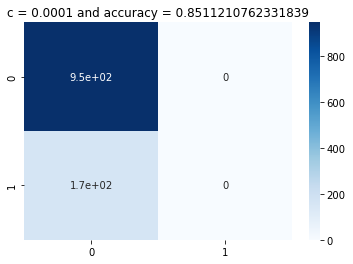

Executing Logistic Regression (L1), C value 0.001
reg is l1


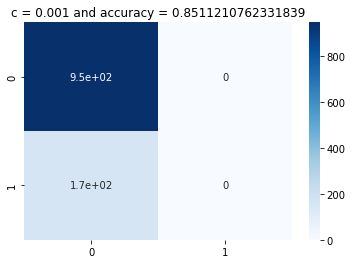

Executing Logistic Regression (L1), C value 0.01
reg is l1


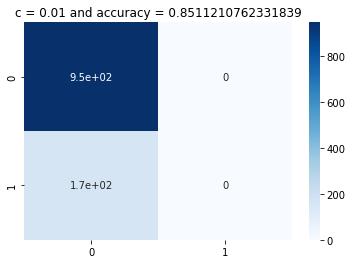

Executing Logistic Regression (L1), C value 0.1
reg is l1


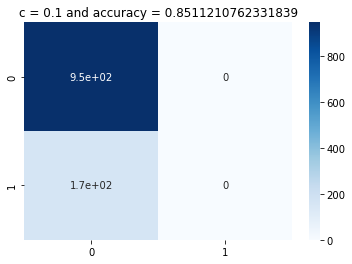

Executing Logistic Regression (L1), C value 1
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


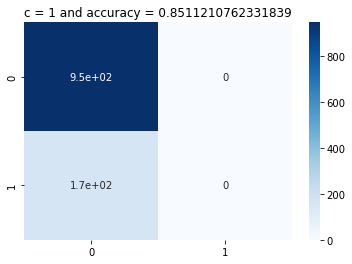

Executing Logistic Regression (L1), C value 10
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


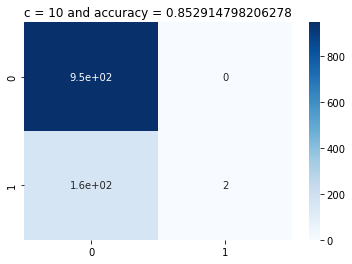

Executing Logistic Regression (L1), C value 100
reg is l1


C:\Users\siddh\Anaconda3\envs\aml\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


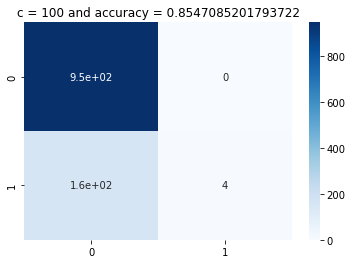

In [84]:
# Executing Logistic regression with l1 regularization and solver SAGA

for c in reg_parameters:
    print("Executing Logistic Regression (L1), C value {}".format(c))
    pred_y, prob_pred, reg_fit, error = logistic_regression(c, wordVecTrain, y_train_w2v, wordVecTest, y_test_w2v, "l1 reg")

# Summary

<b>Accuracy & Error Rate for various models is given below:</b><br/>

<b>TFIDF Vectorization</b><br/>

Naive Bayes (Normal Distribution) : Accuracy = 0.8484 Error Rate = 0.1515<br/>
Naive Bayes (Multinomial Distribution): Accuracy = 0.9748 Error Rate = 0.0251<br/>
Naive Bayes (Categorical Distribution): Accuracy = 0.8511 Error Rate = 0.1488<br/>
Linear Logisitic Regression (without PCA): Accuracy = 0.961 Error Rate = 0.039<br/>
Logistic Regression (with PCA) - Accuracy: 0.97 Error Rate = 0.03<br/>
Logistic Regression (with PCA and n_components): Accuracy = 0.97 Error Rate = 0.03<br/>
KNN (Best K = 1): Accuracy = 0.95 Error Rate = 0.05<br/>
Random Forest: Accuracy = 0.92 Error Rate = 0.08<br/>
SVM (Linear Kernel, Best C = 10): Accuracy = 0.98 Error Rate = 0.02<br/>
SVM (RBF Kernel, Best C = 10): Accuracy = 0.97 Error Rate = 0.03<br/>
SVM (Poly Kernel, Best C = 1,Degree = 3): Accuracy = 0.94 Error Rate = 0.06<br/>
SVM (Poly Kernel, Best C = 10 ,Degree = 5): Accuracy = 0.93 Error Rate = 0.07<br/>
SVM (Poly Kernel, Best C = 10, Degree = 10): Accuracy = 0.92 Error Rate = 0.08<br/>
Neural Networks (Layer = 3, C = 0.001): Accuracy = 0.98 Error Rate = 0.02<br/>
Neural Networks (Layer = 4, C = 0.0001): Accuracy = 0.98 Error Rate = 0.02<br/>
Neural Networks (Layer = 5, C = 0.001): Accuracy = 0.98 Error Rate = 0.02<br/>

<b>Count Vectorization</b>

Naive Bayes (Normal Distribution): Accuracy = 0.8484 Error Rate = 0.1515<br/>
Naive Bayes (Multinomial Distribution): Accuracy = 0.9748 Error Rate = 0.0251<br/>
Naive Bayes (Categorical Distribution): Accuracy = 0.8511 Error Rate = 0.1488<br/>
Logisitic Regression (Penalty=L2, Solver= SAG, C=100) : Accuracy = 0.98 Error Rate = 0.02<br/>
Logisitic Regression (Penalty=L1, Solver= SAGA, C=100) : Accuracy = 0.98 Error Rate = 0.02<br/>
KNN (Best K = 1) : Accuracy = 0.95 Error Rate = 0.05<br/>
Random Forest : Accuracy = 0.92 Error Rate = 0.08<br/>
SVM (Linear Kernel, Best C = 10) : Accuracy = 0.98 Error Rate = 0.02<br/>
SVM (RBF Kernel, Best C= 100) : Accuracy = 0.97 Error Rate = 0.03<br/>
SVM (Poly Kernel, Best C=10,Degree = 3) : Accuracy = 0.94 Error Rate = 0.06<br/>
SVM (Poly Kernel, Best C=100 ,Degree = 5) : Accuracy = 0.93 Error Rate = 0.07<br/>
SVM (Poly Kernel, Best C=10, Degree = 10) : Accuracy = 0.92 Error Rate = 0.08<br/>
Neural Networks (Layer = 3, C = 0.0001) : Accuracy = 0.98 Error Rate = 0.02<br/>
Neural Networks (Layer = 4, C = 0.0001) : Accuracy = 0.98 Error Rate = 0.02<br/>
Neural Networks (Layer = 5, C = 0.0001) : Accuracy = 0.98 Error Rate = 0.02<br/>

<b>Word2Vec Vectorization</b>

Naive Bayes (Normal Distribution) : Accuracy = 0.51 Error Rate = 0.49<br/>
Logisitic Regression (Penalty=L2, Solver= SAG, C=100) : Accuracy = 0.86 Error Rate = 0.14<br/>
Logisitic Regression (Penalty=L1, Solver= SAGA, C=100) : Accuracy = 0.85 Error Rate = 0.15<br/>
KNN (Best K = 11) : Accuracy = 0.94 Error Rate = 0.06<br/>
Random Forest : Accuracy = 0.94 Error Rate = 0.06<br/>
SVM (Linear Kernel, C = 100) : Accuracy = 0.94 Error Rate = 0.06<br/>
SVM (RBF Kernel, C= 100) : Accuracy = 0.94 Error Rate = 0.06<br/>
SVM (Poly Kernel, C=100,Degree=3) : Accuracy = 0.89 Error Rate = 0.11<br/>
SVM (Poly Kernel, C=100 ,Degree=5) : Accuracy = 0.88 Error Rate = 0.12<br/>
SVM (Poly Kernel, C=100, Degree=10) : Accuracy = 0.88 Error Rate = 0.12<br/>
Neural Networks (Layer = 3, C = 0.0001) : Accuracy = 0.95 Error Rate = 0.05<br/>
Neural Networks (Layer = 4, C = 0.001) : Accuracy = 0.95 Error Rate = 0.05<br/>
Neural Networks (Layer = 5, C = 0.0001) : Accuracy = 0.95 Error Rate = 0.05<br/>